In [1]:
# Required by PythonicDISORT
import numpy as np
import scipy as sc
from numpy.polynomial.legendre import Legendre
from math import pi
from scipy import integrate
from warnings import warn

import PythonicDISORT

In [2]:
# Required only in this notebook for tests and exposition
import autograd as ag
import autograd.numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import constants

**Installation and more examples of use**

`pip install PythonicDISORT`

See https://github.com/LDEO-CREW/Pythonic-DISORT for other installation options. See the Jupyter Notebooks in the `pydisotest` directory for more examples of use.

**Setup and overview**

Denote the optical depth as $\tau$, the cosine of the polar angle as $\mu$ (positive is upward), and the azimuthal angle as $\phi$ (positive is counterclockwise when looking down on the atmospheric layer). The goal is to solve the (time-independent and 1D) Radiative Transfer Equation (RTE) for a plane-parallel atmosphere:

$$
\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) &-\frac{\omega}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right) - s(\tau)
\end{aligned}
$$

for the **diffuse** intensity, $u = u_\text{diffuse}$ using the Discrete Ordinates Method. Our setup is equivalent to that of Stamnes et. al. [[1]](#cite-STWJ1988). The total intensity is given by

$$u_\text{total} = u_\text{diffuse} + u_\text{direct}$$

where for downward angles $-\mu_0 < 0$,

$$
\begin{aligned}
&\mu\frac{\partial u_\text{direct}(\tau, \mu, \phi)}{\partial\tau} = u_\text{direct}(\tau, \mu, \phi), \quad u_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \\
&\implies u_\text{direct}(\tau, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}
$$

The fundamental idea behind the Discrete Ordinates Method, from Chandrasekhar [[2]](#cite-Cha1960), is to perform the following series expansions

$$
\begin{aligned}
u\left(\tau, \mu, \phi\right) &\approx \sum_{n=0}^\text{NFourier} u^n\left(\tau, \mu\right)\cos\left(n\left(\phi_0 - \phi\right)\right) \quad \text{(Fourier cosine series)}\\
p\left(\mu, \phi ; \mu', \phi'\right) = p\left(\cos\gamma\right) &\approx \sum_{\ell=0}^\text{NLeg} (2\ell + 1) g_\ell P_\ell\left(\cos\gamma\right) \quad \text{(Legendre series)}
\end{aligned}
$$

which will deal with the $\phi'$ integral, and approximate the $\mu'$ integral using Gauss-Legendre quadrature with $\text{NQuad} = 2N$ quadrature points, i.e.

$$\int_{-1}^1 [\dots] \ \mathrm{d}\mu' \approx \sum_{|j|=1}^\text{N} [\dots]$$

to get a linear system of ODEs which can be solved.

**Multiple atmospheric layers**

In the RTE the single-scattering albedo $\omega$ and scattering phase function $p$ 
are assumed to be independent of $\tau$, i.e. homogeneous in the atmospheric layer.
An atmosphere with $\tau$-dependent $\omega$ and $p$ can be modelled by 
a multi-layer atmosphere with different $\omega$ and $p$ for each layer.

It is mathematically straightforward to generalize the Discrete Ordinates Method to multiple atmospheric layers, each demarcated by $\tau_l$ for index $l = 0, 1, \dots, L$. Until section [3.6](#3.6-General-solution-for-each-mode-and-layer) the method applied to each layer is the identical. The only complication from moving to a multi-layered atmosphere is that the boundary conditions for each layer are coupled and so one would need to implement section [4](#4.-Solve-for-multiple-layers) instead of section [3.6](#3.6-General-solution-for-each-mode-and-layer).

# Table of Contents
* [1. USER INPUT REQUIRED: Choose parameters](#1.-USER-INPUT-REQUIRED:-Choose-parameters)
	* [1.1 Choose optical properties](#1.1-Choose-optical-properties)
	* [1.2 Choose computational parameters](#1.2-Choose-computational-parameters)
	* [1.3 Choose phase function](#1.3-Choose-phase-function)
		* [1.3.1 OPTIONAL: Choose delta-M scaling](#1.3.1-OPTIONAL:-Choose-delta-M-scaling)
	* [1.4 Choose direct beam source](#1.4-Choose-direct-beam-source)
	* [1.5 OPTIONAL: Choose BDRF](#1.5-OPTIONAL:-Choose-BDRF)
	* [1.6 OPTIONAL: Choose boundary sources](#1.6-OPTIONAL:-Choose-boundary-sources)
	* [1.7 OPTIONAL: Choose isotropic internal source](#1.7-OPTIONAL:-Choose-isotropic-internal-source)
* [2. PythonicDISORT modules and outputs](#2.-PythonicDISORT-modules-and-outputs)
* [3. Breakdown of single layer solver](#3.-Breakdown-of-single-layer-solver)
	* [3.1 Quadrature](#3.1-Quadrature)
	* [3.2 Fourier expansion of solution](#3.2-Fourier-expansion-of-solution)
		* [3.2.1 Surface reflection](#3.2.1-Surface-reflection)
		* [3.2.2 Important terms](#3.2.2-Important-terms)
	* [3.3 Delta-M scaling](#3.3-Delta-M-scaling)
		* [3.3.1 Scaling a multi-layer atmosphere](#3.3.1-Scaling-a-multi-layer-atmosphere)
	* [3.4 System of ODEs](#3.4-System-of-ODEs)
		* [3.4.1 How to choose NQuad and NLeg?](#3.4.1-How-to-choose-NQuad-and-NLeg?)
		* [3.4.2 Assembly of system](#3.4.2-Assembly-of-system)
	* [3.5 Diagonalization of coefficient matrix](#3.5-Diagonalization-of-coefficient-matrix)
	* [3.6 General solution for each mode and layer](#3.6-General-solution-for-each-mode-and-layer)
		* [3.6.1 The particular solutions](#3.6.1-The-particular-solutions)
		* [3.6.2 The homogeneous solution](#3.6.2-The-homogeneous-solution)
		* [3.6.3 Verification of the general solution](#3.6.3-Verification-of-the-general-solution)
	* [3.7 The full solution](#3.7-The-full-solution)
		* [3.7.1 Verification and visualization: uncorrected](#3.7.1-Verification-and-visualization:-uncorrected)
		* [3.7.2 NT corrections](#3.7.2-NT-corrections)
		* [3.7.3 Verification and visualization: NT corrected](#3.7.3-Verification-and-visualization:-NT-corrected)
	* [3.8 Computation of flux](#3.8-Computation-of-flux)
		* [3.8.1 Impact of delta-M scaling on flux calculations](#3.8.1-Impact-of-delta-M-scaling-on-flux-calculations)
		* [3.8.2 Verification of flux](#3.8.2-Verification-of-flux)
		* [3.8.3 Reflectance and transmittance](#3.8.3-Reflectance-and-transmittance)
* [4. Solve for multiple layers](#4.-Solve-for-multiple-layers)
	* [4.1 Verification of multi-layer solver](#4.1-Verification-of-multi-layer-solver)
* [5. Timing PythonicDISORT](#5.-Timing-PythonicDISORT)
* [6. Comparisons against Stamnes' DISORT](#6.-Comparisons-against-Stamnes'-DISORT)
	* [6.1 Flux comparisons](#6.1-Flux-comparisons)
	* [6.2 Intensity comparisons](#6.2-Intensity-comparisons)
	* [6.3 Intensity comparisons at interpolation points](#6.3-Intensity-comparisons-at-interpolation-points)
	* [6.4 PyTest](#6.4-PyTest)
	* [6.5 Timing Stamnes' DISORT](#6.5-Timing-Stamnes'-DISORT)


# 1. USER INPUT REQUIRED: Choose parameters

These inputs are for the solver function `pydisort`. Input checks are performed in `pydisort.py`. Refer to the `*_test.ipynb` Jupyter Notebooks in the `pydisotest` directory for more examples. Our notations somewhat follow those of Stamnes et. al. (1988) [[1]](#cite-STWJ1988) **with the equivalent variable in their FORTRAN DISORT code** [[3]](#cite-Sta1999) **in brackets if available**.

## 1.1 Choose optical properties

The phase function will be chosen later in section [1.3](#1.3-Choose-phase-function).

* **Optical depth (DTAUC denotes the optical thickness of each layer)**

Take $\tau = 0$ to be the top of the atmosphere. The first (zeroth index) atmospheric layer from the top has optical thickness $\tau_0$ and each subsequent layer $l$ has optical thickness $\tau_l - \tau_{l-1}$. The number of layers $\text{NLayers}$ (denoted $\text{NLYR}$ in Stamnes' DISORT [[3]](#cite-Sta1999)) is set by `len(tau_arr)`. Users should consider truncating thick atmospheres that have significant absorption. We require each $\tau_l$ and the optical thickness of each layer to be positive.

In [3]:
# While we specify multiple atmospheric layers for illustrative purposes, every layer
# has identical optical properties, and so this model is equivalent to a one layer model

#################### SUPPLIED TO PYDISORT ########################

tau_arr = np.arange(16) / 2 + 0.5

##################################################################

In [4]:
# Used internally in PythonicDISORT
NLayers = len(tau_arr)

* **Single-scattering albedo (SSALB)**

As before, **the zeroth index corresponds to the layer at the top of the atmosphere**. Within each layer, $\omega$ is assumed to be independent from $\tau$. We require each $\omega \in [0,1)$ and values too close to $1$ (paired with phase function Legendre coefficients that are too close to $1$) will cause instability. For conservative atmospheres we recommend an approximation of $\omega \sim 1 - 10^{-6}$ (and phase function Legendre coefficients should be capped at $0.95$). These soft caps can be higher if `only_flux = True` or delta-scaling is applied (`f_arr > 0`). See section [3.5](#3.5-Diagonalization-of-coefficient-matrix) for more details.

In [5]:
#################### SUPPLIED TO PYDISORT ########################

omega_arr = np.full(NLayers, 1 - 1e-6)

##################################################################

## 1.2 Choose computational parameters

* **Number of quadrature points for the** $\mu'$ **integral (NSTR)**

This parameter is also known as the number of "streams" in the radiation literature and in Stamnes' DISORT [[3]](#cite-Sta1999). We require an even $\text{NQuad} \geq 2$. This parameter incurs the largest computational cost in `pydisort`, with scaling like $\mathcal{O}\left(\text{NQuad}^3\right)$. An excessive number of streams will cause numerical instability: if $\text{NQuad} \gtrsim 300$ some quadrature angles will be extremely glancing ($\mu \sim 0$) and the computed intensity at those angles may be inaccurate.

In [6]:
#################### SUPPLIED TO PYDISORT ########################

NQuad = 16

##################################################################

Define $N = \text{NQuad} \ / \ 2$. This variable will be used extensively.

In [7]:
N = NQuad // 2

* **(OPTIONAL) Number of phase function Legendre coefficients to use**

We require $\text{NLeg} \leq \text{NQuad}$. In general, we recommend choosing `NLeg = NQuad` which the default value for `NLeg` and the only option allowed in Stamnes' DISORT [[3]](#cite-Sta1999). See section [3.4.1](#3.4.1-How-to-choose-NQuad-and-NLeg?) for an explanation of this requirement.

In [8]:
#################### SUPPLIED TO PYDISORT ########################

NLeg = NQuad

##################################################################

* **(OPTIONAL) Number of Fourier modes to use in the intensity function**

The number of Fourier modes must be positive and cannot exceed the number of phase function Legendre coefficients ($\text{NLeg}$). The default is `NFourier = NQuad` though if $\text{NFourier}$ is too large it may cause problems. We recommend $\text{NFourier} \leq 64$ and it should often be much lower. See section [3.4.1](#3.4.1-How-to-choose-NQuad-and-NLeg?) for an explanation of this parameter and how it is adaptive in Stamnes' DISORT [[3]](#cite-Sta1999). Note that `only_flux = True` overwrites this parameter and is equivalent to `NFourier = 1`, except that `only_flux = True` will also cause the intensity function to not be returned. 

In [9]:
#################### SUPPLIED TO PYDISORT ########################

NFourier = NQuad # Maximum NFourier

##################################################################

* **(OPTIONAL) Whether to compute only the flux, or compute both flux and intensity (ONLYFL)**

If `only_flux = True` (default is `False`), PythonicDISORT will be much faster because only the $0$th Fourier mode equation needs to be solved, see section [3.8](#3.8-Computation-of-flux).

In [10]:
#################### SUPPLIED TO PYDISORT ########################

only_flux = False

##################################################################

* **(OPTIONAL) Threshold to use** `scipy.linalg.solve_banded`

As the number of atmospheric layers increases, the matrix used in solving for the coefficients of the homogenous solution gets sparser and becomes banded, see section [4](#4.-Solve-for-multiple-layers). The banded solver `scipy.linalg.solve_banded` is used if `NLayers >= use_banded_solver_NLayers`. The default is `10` and the minimum is `3`.

In [11]:
#################### SUPPLIED TO PYDISORT ########################

use_banded_solver_NLayers = 10

##################################################################

* **(OPTIONAL) Should output functions be compatible with the *autograd* package: https://github.com/HIPS/autograd?**

In [12]:
#################### SUPPLIED TO PYDISORT ########################

autograd_compatible = False

##################################################################

If `True`, the *autograd* package, if installed, can be used to compute the $\tau$-derivatives of the output functions but `pydisort` and function evaluations will be (slightly) less efficient. The default is `False`.

## 1.3 Choose phase function

***Background and fundamental assumption of spherical symmetry***

Assume that the phase function is directly dependent on only the scattering angle $\gamma$, i.e. the scattering medium has spherical symmetry. Then, follow the method in [[1]](#cite-STWJ1988) and expand the phase function in a Legendre series with respect to $\cos\gamma$ (our notations and definitions differ slightly):

$$
p(\cos\gamma) \approx \sum_{\ell=0}^\text{NLeg} (2\ell + 1)g_\ell P_\ell(\cos\gamma), \quad g_\ell = \frac{1}{2}\int_{-1}^{1} p(\cos\gamma) P_\ell(\cos\gamma) \mathrm{d}\cos\gamma
$$

The scattering angle $\gamma$ is between the incident angular vector $\left(\theta', \phi'\right)$ and the outgoing angular vector $(\theta, \phi)$ such that

$$
\begin{aligned}
\cos\gamma &= \cos\theta'\cos\theta + \sin\theta'\sin\theta\cos\left(\phi'-\phi\right) \\
\iff \nu &= \mu' \mu + \sqrt{1 - \mu'^2} \sqrt{1 - \mu^2} \cos\left(\phi'-\phi\right)
\end{aligned}
$$

where

$$
\nu = \cos\gamma, \quad \mu = \cos\theta, \quad\mu' = \cos\theta'
$$

Therefore, by the addition theorem for spherical harmonics

$$
P_\ell(\nu) = P_\ell\left(\mu'\right)P_\ell(\mu) + 2\sum_{m=1}^\ell \frac{(\ell-m)!}{(\ell+m)!}P_\ell^m\left(\mu'\right)P_\ell^m(\mu)\cos\left(m\left(\phi'-\phi\right)\right)
$$

In general, we will use the $\nu$-argument form in PythonicDISORT as it is the most straightforward to integrate. In our exposition, however, we will generally express a phase function with arguments $\mu, \phi, \mu', \phi'$ for consistency with the radiative transfer equation.

***Henyey-Greenstein phase function***

This definition excludes $\omega$ and is normalized to $1$,

$$p(\nu) = \frac{1-g^2}{\left(1+g^2-2 g \nu\right)^{3 / 2}}$$

In [13]:
p_HG_nu = lambda nu: (1 - g**2) / (1 + g**2 - 2 * g * nu) ** (3 / 2)

In [14]:
def p_HG_muphi(mu, phi, mu_p, phi_p):
    nu = PythonicDISORT.subroutines.calculate_nu(mu, phi, mu_p, phi_p)
    return p_HG_nu(nu)

**Asymmetry factor (GG)**

The magnitude of $g$ must be less than $1$ and magnitudes close to $1$ will cause instability. We recommend a soft cap of $|g| = 0.95$ though this can be higher if $\omega$ is low, `only_flux = True`, or delta-scaling is applied (`f_arr > 0`).

In [15]:
g = 0.75

**Number of phase function Legendre coefficients supplied (NMOM)**

In [16]:
NLeg_all = 32

* **Unweighted phase function Legendre coefficients** $g_\ell$ **(PMOM)**

We require at least $\text{NLeg}$ coefficients each between $-1$ and $1$ inclusive. For a multi-layer atmosphere, `Leg_coeffs_all` must be a matrix which $l$th row index corresponds to the atmospheric layer indexed by $l$.

In [17]:
#################### SUPPLIED TO PYDISORT ########################

Leg_coeffs_all = np.tile(g ** np.arange(NLeg_all), (NLayers, 1))

##################################################################

# Used internally in PythonicDISORT
Leg_coeffs = Leg_coeffs_all[:, :NLeg]

We encourage having `Leg_coeffs_all` contain as many phase function Legendre coefficients as are available. PythonicDISORT will for most part use only $\text{NLeg}$ coefficients, but the remaining coefficients are important for approximating the true phase function as accurately as possible for NT corrections, see section [3.7.2](#3.7.2-NT-corrections).

***Rayleigh phase function (not used in this Notebook)***

$$p(\nu) = \frac{3}{8} (1 + \nu^2)$$

In [18]:
p_R_nu = lambda nu: (3 / 8) * (1 + nu**2)  # Not used in this Notebook
#Leg_coeffs_all = np.zeros(16)
#Leg_coeffs_all[0] = 1
#Leg_coeffs_all[2] = 0.1

### 1.3.1 OPTIONAL: Choose delta-M scaling

Standard Legendre series approximation of highly anisotropic phase functions require a large number of terms to accurately capture the strong directional scattering. This is due to the slow decay of the coefficients. Using the HG phase function as an illustrative example, its Legendre coefficients are given by $\mathscr{g}_\ell = g^\ell$ where $g$ is the asymmetry factor. The closer $|g|$ is to $1$, i.e. the more anisotropic the HG phase function, the slower its coefficients decay.

Fewer Legendre terms are required for accuracy if the phase function is re-expressed as a linear combination of a Dirac $\delta$-function and a more isotropic remainder. We follow the method in [[5]](#cite-Wis1977) for scaling the first $2M$ Legendre coefficients of a phase function such that they become the coefficients of the remainder.

$$
\begin{aligned}
&p(\nu) \approx 2 f \delta(1-\nu) + (1 - f) \sum_{\ell=0}^{2 M-1} (2\ell + 1) g_\ell^* P_\ell(\nu), \quad g^*_\ell = \frac{g_\ell - f}{1 - f} \\
&\iff p\left(\mu, \phi; \mu', \phi'\right) \approx 4 \pi f \delta\left(\mu - \mu'\right)\delta\left(\phi - \phi'\right) + (1 - f) p^*\left(\mu, \phi; \mu', \phi'\right)
\end{aligned}
$$

where the fractional scattering into peak parameter $f \in [0, 1]$ is user-specified, with $f = 0$ equivalent to no $\delta-M$ scaling. The first $2M$ Legendre coefficients of this re-expression will agree with those of the phase function. Mathematically, this method approximates the truncated tail of the phase function Legendre series as a series with coefficients set to $f$ (instead of $0$). 

The standard choice is $f = g_{2M} = g_\text{NLeg}$ so that the first $2M + 1$, and not just $2M$, Legendre coefficients of the re-expression agree with those of the phase function. This choice is automatic in Stamnes' DISORT [[3]](#cite-Sta1999). Choosing $f = g_{2M}$ with $M = 1$ is equivalent to the delta-Eddington method, see [[6]](#cite-JWW1976). We will discuss the impact of this phase function re-expression on the RTE in section [3.3](#3.3-Delta-M-scaling).

* **(OPTIONAL) Fractional scattering into peak parameter (Automatically chosen in Stamnes' DISORT** [[3]](#cite-Sta1999)**)**

We require $f \in [0, 1)$ and the default is `0` (no scaling). Values close to $1$ will cause instability. The zeroth entry of the array corresponds to the zeroth (topmost) atmospheric layer. We recommend setting `f_arr` to ``Leg_coeffs_all[NQuad]``, or ``Leg_coeffs_all[:, NQuad]`` for a multi-layer atmosphere.

In [19]:
#################### SUPPLIED TO PYDISORT ########################

f_arr = np.full(NLayers, Leg_coeffs_all[0, NLeg])

##################################################################

* **(OPTIONAL) Whether to perform Nakajima-Tanaka intensity corrections, see section** [3.7.2](#3.7.2-NT-corrections) **(Always true in Stamnes' DISORT** [[3]](#cite-Sta1999)**)**

Our default is `False`. In practice this is often set to `True` though the corrections incur significant computational costs.

In [20]:
#################### SUPPLIED TO PYDISORT ########################

NT_cor = False

##################################################################

## 1.4 Choose direct beam source

* **Parameters for the incident direct collimated beam of starlight**

If `NT_cor = True`, then to prevent singularities in the NT corrections $\mu_0$ must not coincide with a quadrature angle, see section [3.7.2](#3.7.2-NT-corrections). If that happens either $\text{NQuad}$ or $\mu_0$ should be tweaked. In addition, we do not allow $\mu_0 \leq 0$ and small $\mu_0$ values will cause instability. We require both angles to be principal and $I_0 \geq 0$. Choosing $I_0 = 0$ will disable this source. The flux contribution of this source is $I_0 \mu_0$.

In [21]:
#################### SUPPLIED TO PYDISORT ########################

# Cosine of polar angle (UMU0) -- MOST IMPORTANT
mu0 = 0.6
# Intensity (FBEAM) -- Simply a scale factor
I0 = 100
# Azimuthal angle (PHI0) -- No effect on fluxes
phi0 = 0.9 * pi

##################################################################

**Rescale of sources**

Given lone source $\mathcal{S} = \mathcal{S}_0$, e.g. $I_0 = \mathcal{S}_0$, $\mathcal{S}_0$ is a simple scale factor for the outputs, i.e. for all $\tau, \phi,  \mathcal{S}_0$,

$$\frac{u(\tau, \phi; \mathcal{S} = \mathcal{S}_0)}{u(\tau, \phi; \mathcal{S} = 1)} = \mathcal{S}_0 = \frac{F(\tau; \mathcal{S} = \mathcal{S}_0)}{F(\tau;  \mathcal{S} = 1)}$$

where $F$ is any of the different types of fluxes, see section [3.8](#3.8-Computation-of-flux). PythonicDISORT will internally rescale sources for numerical stability.

Users should be careful with large inputs. The resolution of `float64`, per `numpy.finfo`, is $10^{-15}$ and so scaling values up with $I_0 = 10^{15}$, for example, will greatly magnify computational noise and result in boundary conditions appearing unsatisfied among other problems.

## 1.5 OPTIONAL: Choose BDRF

Denote the Bi-Directional Reflectance Function (BDRF) as $q$. Assume that the BDRF can be expressed as a Fourier cosine series with respect to $\Delta \phi := \phi' - \phi$; this is weaker than the spherical symmetry assumption made in section [1.3](#1.3-Choose-phase-function). The BDRF argument should be a **list** of length less than or equal to $\text{NFourier}$, which $m$-indexed element is either a scalar (the function is constant) or the $m$th Fourier mode function

$$q^m\left(\mu, -\mu'\right) = \frac{1}{(1 + \delta_{0m})\pi}\int_0^{2\pi} q\left(\mu, \phi; -\mu', \phi'\right)\cos(m\Delta \phi) \mathrm{d}(\Delta \phi)$$

with exactly two arguments $\mu, -\mu' > 0$ of type **array** and its output must have the **same dimensions as the outer product** $\mu \otimes -\mu'$.

***Lambertian BDRF***

$$q\left(\mu, \phi; -\mu', \phi'\right) = \omega_s$$

This BDRF has only the zeroth Fourier mode $\omega_s$.

**Surface albedo (ALBEDO)**

In [22]:
omega_s = 0.1 # Ocean albedo is approximately 0.1

 * **(OPTIONAL) BDRF Fourier modes (No direct equivalent in Stamnes' DISORT** [[3]](#cite-Sta1999)**, but see variables *BDREF* and *LAMBER*)**
 
The number of BDRF Fourier modes must be non-negative and $\leq \text{NLeg}$. The default is a black surface, i.e. $q\left(\mu, \phi; -\mu', \phi'\right) = 0$. If the same BDRF and number of streams ($\text{NQuad}$) and/or solar zenith angle ($\mu_0$) will be used repeatedly, consider caching `BDRF_Fourier_modes` using `PythonicDISORT.subroutines.cache_BDRF_Fourier_modes` and instead input `cached_BDRF_Fourier_modes` into `pydisort`.

In [23]:
#################### SUPPLIED TO PYDISORT ########################

BDRF_Fourier_modes = [omega_s] # Equivalent alternative for `pydisort`
BDRF_Fourier_modes = [lambda mu, neg_mup: np.full((len(mu), len(neg_mup)), omega_s)]

##################################################################

# Used internally in PythonicDISORT
NBDRF = len(BDRF_Fourier_modes)

## 1.6 OPTIONAL: Choose boundary sources

 * **(OPTIONAL) Boundary sources, i.e. Dirichlet boundary conditions (FISOT is similar to** $b^-$**)**

$$
u\left(\tau_{\text{BoA}}, \mu_i, \phi \right) = \sum_{m = 0}^{\text{NFourier}}b^+_{im}\cos(m(\phi_0 - \phi)), \quad u(0, -\mu_i, \phi) = \sum_{m = 0}^{\text{NFourier}}b^-_{im}\cos(m(\phi_0 - \phi))
$$

for $i = 1, \dots, N$, where $b^\pm$ are matrices to be specified and "BoA" stands for "Bottom of Atmosphere".

If $u\left(\tau_{\text{BoA}}, \mu, \phi \right) = \psi^+(\mu, \phi)$ and $u\left(0, -\mu, \phi \right) = \psi^-(\mu, \phi)$, then $\psi^+$ and $\psi^-$ must first be discretized in $\mu$, following which $b^+_{im}$ and $b^-_{im}$ are the truncated Fourier coefficients of $\psi^+_i$ and $\psi^-_i$ respectively. Note that `PythonicDISORT.subroutines.Gauss_Legendre_quad(N)[0]` can be used to get the grid points $\mu_i$. We require $\psi^+$ and $\psi^-$ to be even about some $\phi$ value (not necessarily $\phi_0$) for them to be compatible with the pure cosine series expansion of the solution. Each BC input must be a matrix of dimension $N \times \text{NLeg}$, a vector of length $N$, or a scalar. If the input is a vector the BC will be taken to be **azimuthally-averaged anisotropic radiation**, e.g. `b_neg = np.arange(N)` implies

$$b^-_{i0} = i, b^-_{im} = 0 \quad \forall m = 1, \dots, \text{NFourier}, \forall i = 1, \dots, N$$

and a scalar input would simply be broadcasted to a vector of length $N$. A scalar `b_neg` is equivalent to the argument `FISOT` in Stamnes' DISORT [[3]](#cite-Sta1999) plus blackbody emission from the bottom boundary. The contribution of blackbody emission to `b_pos` or `b_neg` can be computed using `PythonicDISORT.subroutines.blackbody_contrib_to_BCs`. Users are responsible for determining emissivities, though `PythonicDISORT.subroutines.generate_emissivity_from_BDRF` can be used to determine the (directional) emissivity of the surface given the BDRF (see section [1.5](#1.5-OPTIONAL:-Choose-BDRF)) in accordance with Kirchoff's law of thermal radiation.

The defaults are `b_pos = 0` and `b_neg = 0` (homogeneous BCs).

In [24]:
#################### Parameters to choose ########################

WVNMLO = 0 # Lower bound of wavenumber interval with units m^-1
WVNMHI = 50000 # Upper bound of wavenumber interval with units m^-1

T_Surf = 288  # Average surface temperature in kelvin
T_CMB = 2.7 # Temperature for cosmic microwave background radiation in kelvin

##################################################################

emissivity_top_boundary = 1
emissivity_surface = PythonicDISORT.subroutines.generate_emissivity_from_BDRF(NQuad // 2, BDRF_Fourier_modes[0])
print(emissivity_surface) # Consistent with choice of `omega_s`

[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]


In [25]:
#################### SUPPLIED TO PYDISORT ########################

# At bottom of atmosphere
b_pos = (
    PythonicDISORT.subroutines.blackbody_contrib_to_BCs(T_Surf, WVNMLO, WVNMHI)
    * emissivity_top_boundary
)

# At top of atmosphere
b_neg = (
    PythonicDISORT.subroutines.blackbody_contrib_to_BCs(T_CMB, WVNMLO, WVNMHI)
    * emissivity_surface
)

##################################################################

# Code within `pydisort` to ensure that the BC inputs are of the correct shape
b_pos_is_scalar = False
b_neg_is_scalar = False
b_pos_is_vector = False
b_neg_is_vector = False

if len(np.atleast_1d(b_pos)) == 1:
    b_pos_is_scalar = True
elif len(b_pos) == N:
    b_pos_is_vector = True
elif not np.shape(b_pos) == (N, NFourier):
    raise ValueError("The shape of the bottom boundary condition is incorrect.")
if len(np.atleast_1d(b_neg)) == 1:
    b_neg_is_scalar = True
elif len(b_neg) == N:
    b_neg_is_vector = True
elif not np.shape(b_neg) == (N, NFourier):
    raise ValueError("The shape of the top boundary condition is incorrect.")

## 1.7 OPTIONAL: Choose isotropic internal source

For each atmospheric layer $l$, assume the **scalar** function

$$s_l(\tau) = \mathscr{a}_{l0} + \mathscr{a}_{l1} \tau + \dots + \mathscr{a}_{ln} \tau^n$$

If the true $s_l$ is not polynomial then the above should be a polynomial approximation. Note that continuity between layers is not required. The coefficient matrix $\mathscr{a}$ defaults to an empty matrix which means no isotropic internal sources.

* **(OPTIONAL) Coefficient matrix** $\mathscr{a}$

**Example with parameters: Blackbody radiation**

Let $B$ denote the Planck function for intensity leaving a blackbody surface, with units $W m^{-2}$ to match Stamnes' DISORT [[3]](#cite-Sta1999). For each layer $l$, let the isotropic internal source be blackbody emission:

$$s_l(\tau) = \epsilon_l \int_{\tilde{\nu}_0}^{\tilde{\nu}_1} B\left(T(\tau); \tilde{\nu}\,\right) \mathrm{d}\tilde{\nu}$$

for some wavenumber interval $[\tilde{\nu}_0, \tilde{\nu}_1]$ (see [[4, section 3.2.3]](#cite-STWLE2000) on the nuances of integrating the Planck function) and emissivities $\epsilon_l$ that, by Kirchoff's law of thermal radiation, should equal $1 - \omega_l$. Both PythonicDISORT and DISORT enforce Kirchoff's law. Following [[4, section 2.5]](#cite-STWLE2000), it is common to use linear splines to profile the blackbody emission, i.e. in each layer $l$,

$$B(T(\tau)) = a_{l0} + a_{l1} \tau$$

for user-specified constants $a_{l0}, a_{l1}$. The convenience function `PythonicDISORT.subroutines.generate_s_poly_coeffs` is provided to generate `s_poly_coeffs` such that the outputs of PythonicDISORT will match those of Stamnes' DISORT given the same inputs. PythonicDISORT allows much more flexibility in choosing blackbody emission profiles than DISORT though.

In [26]:
#################### (DISORT) Parameters to choose ########################

WVNMLO = 0 # Lower bound of wavenumber interval with units m^-1
WVNMHI = 50000 # Upper bound of wavenumber interval with units m^-1

T_ToA = 250  # Temperature at Top of Atmosphere in kelvin
T_BoA = 300  # Temperature at Bottom of Atmosphere in kelvin
TEMPER = np.linspace(T_ToA, T_BoA, NLayers + 1) # These values pertain to boundaries / interfaces, not layers

###########################################################################

In [27]:
###################################### SUPPLIED TO PYDISORT #########################################

# This is the coefficient matrix \mathscr{a}
s_poly_coeffs = PythonicDISORT.subroutines.generate_s_poly_coeffs(
    tau_arr, TEMPER, WVNMLO, WVNMHI
)
#s_poly_coeffs = np.concatenate([s_poly_coeffs, s_poly_coeffs / 100], axis=-1)

#####################################################################################################

# Used internally in PythonicDISORT
Nscoeffs = np.shape(s_poly_coeffs)[1]

In [28]:
# Used only in tests
def s(tau):
    l = np.argmax(tau[:, None] <= tau_arr[None, :], axis=1)
    return np.einsum(
        "tc, tc -> t",
        tau[:, None] ** np.arange(Nscoeffs)[None, :],
        s_poly_coeffs[l, :],
        optimize=True,
    )

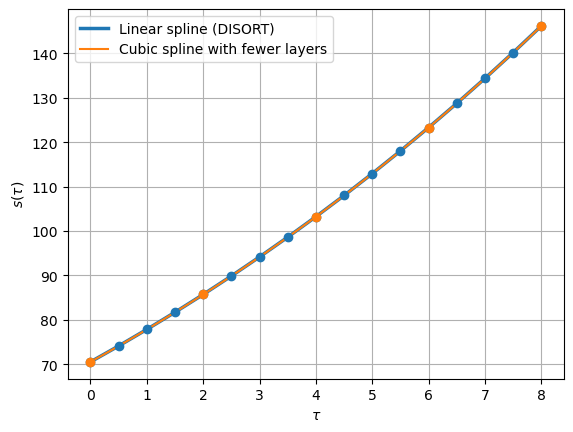

In [29]:
tau_plot = np.linspace(0, tau_arr[-1], 100)
tau_arr_with_0 = np.insert(tau_arr, 0, 0)
plt.plot(tau_plot, s(tau_plot), label="Linear spline (DISORT)", linewidth=2.5)
plt.plot(
    tau_plot,
    sc.interpolate.CubicSpline(tau_arr_with_0[0::4], s(tau_arr_with_0[0::4]))(tau_plot),
    label="Cubic spline with fewer layers",
)
plt.plot(tau_arr_with_0, s(tau_arr_with_0), "o", color="#1f77b4")
plt.plot(tau_arr_with_0[0::4], s(tau_arr_with_0[0::4]), "o", color="#ff7f0e")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$s(\tau)$")
plt.legend()
plt.grid()

# 2. PythonicDISORT modules and outputs

The PythonicDISORT package has two public modules: `pydisort` and `subroutines`. The `pydisort` module contains a single eponymous function. The `subroutines` module contains miscellaneous functions that are called in `pydisort`, provide additional features like interpolation, or are useful for testing.

**The outputs of the** `pydisort` **function**

The solver function `pydisort` will always return `mu_arr` (type: array), `flux_up` (type: function), `flux_down` (type: function) and `u0` (type: function). The array `mu_arr` contains the $\mu_i$ values, i.e. the $\mu$ quadrature nodes. Input `tau` $\tau$ into `flux_up` $F^+$ and `flux_down` $F^-$ to get the diffuse fluxes at the specified optical depths. The latter also returns the direct flux as its second output. More details on the flux functions can be found in section [3.8](#3.8-Computation-of-flux). The distinction between "direct" and "diffuse" is explained in the introduction.

The function `u0` $u^0$ is the zeroth Fourier moment of the (diffuse) intensity, i.e. the azimuthal average, and it is continuous in $\tau$ (its sole argument) but discrete in $\mu$ and fixed to the quadrature points $\mu_i$. The function output is 2D and its $0, 1$ axes capture variation with $\mu$ and $\tau$ respectively. The first half of the $\mu$ indices correspond to the upward direction and the second half to the downward direction in alignment with `mu_arr`. This function is useful for calculating actinic flux and other intensity moments, but reclassification of delta-scaled flux (see section [3.8.1](#3.8.1-Impact-of-delta-M-scaling-on-flux-calculations)) and other corrections must be done manually (actinic flux can be calculated by inputing `u0` into `PythonicDISORT.subroutines.generate_diff_act_flux_funcs` and the flux reclassification will be automatic).

When `only_flux = False` (default), `pydisort` will also output the intensity function `u` $u$ which is continuous in $\tau$ and $\phi$, which are its arguments, but discrete in $\mu$ and fixed to the quadrature points $\mu_i$. The function output is 3D and its $0, 1, 2$ axes capture variation with $\mu, \tau, \phi$ respectively. The function also has the optional flag `return_Fourier_error` which defaults to `False`, see section [3.7](#3.7-The-full-solution) for more details.

In addition, each function has the optional flag `indefinite_tau_integral` (defaults to `False`) which if set to `True` switches to an antiderivative of the function with respect to $\tau$. For example, `flux_up(tau0, is_antiderivative_wrt_tau=True) - flux_up(0, is_antiderivative_wrt_tau=True)` will give the integral of `flux_up` over $\tau \in [0, \tau_0]$. Finally, they have the optional flag `return_tau_arr` to determine whether they will return `tau_arr` as their last output.

# 3. Breakdown of single layer solver

In this section we break down and explain the code for solving the radiative transfer equation for a single atmospheric layer. Unless otherwise stated, we will disable $\delta-M$ scaling (`f = 0`), NT corrections (`NT_cor = False`) and have no isotropic internal sources, i.e. `s_poly_coeffs=np.array([[]])`. We will explain $\delta-M$ scaling and NT corrections in their independent subsections.

**Tensor product coding philosophy**

We use the following methods in order of preference:

* Broadcasting: e.g. outer product of `array1` and `array2` is coded as `array1[:, None] * array2[None, :]`.
* NumPy `einsum` (Einstein's summation convention) function with `optimize = True`. The documentation can be found at https://numpy.org/doc/stable/reference/generated/numpy.einsum.html.

We believe that this is the best balance between code readability and speed. Other common NumPy functions for tensor products are `numpy.outer` and `numpy.tensordot` but we do not use them.

**Inconsistencies between Notebook code and package code**

The many refactors and optimizations of PythonicDISORT has caused its code to diverge from the code in this Notebook. Consider the code documented here to be illustrative rather than exact. Moreover, a DISORT implementation that follows the code in this Notebook will be functional, just less performant.

## 3.1 Quadrature

We use Double Gauss-Legendre quadrature weights and points to numerically integrate over $\mu$ from $-1$ to $1$.

In [30]:
# For positive mu values (the weights are identical for both domains)
mu_arr_pos, W = PythonicDISORT.subroutines.Gauss_Legendre_quad(N) # mu_arr_neg = -mu_arr_pos
mu_arr = np.concatenate([mu_arr_pos, -mu_arr_pos])
full_weights_mu = np.concatenate([W, W])

Test integral:

$$\int_{a}^{b} e^x \mathrm{d}x = e^b - e^a$$

In [31]:
# Double Gauss-Legendre quadrature; integrate from -1 to 1
true_sol = np.exp(1) - np.exp(-1)

print(
    "Gauss-Legendre quadrature error ratio =",
    np.abs((true_sol - np.sum(np.exp(mu_arr) * full_weights_mu)) / true_sol),
)

Gauss-Legendre quadrature error ratio = 0.0


In [32]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1   

We use Clenshaw-Curtis quadrature to numerically integrate over $\phi$ from $0$ to $2\pi$. This will only be used in tests.

In [33]:
# Clenshaw-Curtis quadrature; integrate from -1 to 1
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)
true_sol = np.exp(2 * pi) - 1

print(
    "Clenshaw-Curtis quadrature error ratio =",
    np.abs((true_sol - np.sum(np.exp(phi_arr) * full_weights_phi)) / true_sol),
)

Clenshaw-Curtis quadrature error ratio = 2.1270086547936496e-16


## 3.2 Fourier expansion of solution

*We will re-derive equations (6a) to (6d) of* [[1]](#cite-STWJ1988) *in this subsection.*

The goal is to turn the problem of solving the radiative transfer equation

$$
\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) &-\frac{\omega}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right) - s(\tau)
\end{aligned}
$$

into the problem of solving

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\mu, \mu'\right) u^m\left(\tau, \mu'\right) \mathrm{d} \mu' - Q^m(\tau, \mu) - \delta_{0m}s(\tau)
$$

for each Fourier mode $m$, where $\delta_{0m}$ is the Kronecker delta for indices $0$ and $m$.

**Definitions and expansions**

The relevant definitions and expansions are

$$
\begin{aligned}
u\left(\tau, \mu, \phi\right) &\approx \sum_{m=0}^\text{NFourier} u^m\left(\tau, \mu\right)\cos\left(m\left(\phi_0 - \phi\right)\right) \quad \text{(Fourier cosine series)} \\
p\left(\mu, \phi ; \mu', \phi'\right) = p\left(\nu\right) &\approx \sum_{\ell=0}^\text{NLeg} \mathscr{g}_\ell P_\ell\left(\nu\right) \quad \text{(Legendre series)}
\end{aligned}
$$
$$
\begin{aligned}
\mathscr{g}_\ell &= \frac{2\ell + 1}{2}\int_{-1}^{1} p\left(\nu\right) P_\ell\left(\nu\right) \mathrm{d}\nu, \quad &&\mathscr{g}_\ell^m = \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!} \mathscr{g}_\ell
\end{aligned}
$$

where $\mathscr{g}_\ell$ are the *weighted* Legendre coefficients, $\mathscr{g}_\ell = (2 \ell + 1) g_\ell$. As elaborated upon in section [1.3](#1.3-Choose-phase-function),

$$
P_\ell\left(\nu\right) = P_\ell\left(\mu'\right)P_\ell\left(\mu\right) + 2\sum_{m=1}^\ell \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!}P_\ell^m\left(\mu'\right)P_\ell^m\left(\mu\right)\cos\left(m\left(\phi'-\phi\right)\right)
$$

Consequently, the $\mu, \phi, \mu', \phi'$ form of the phase function can be expanded as

$$
p\left(\mu, \phi; \mu', \phi'\right) \approx \sum_{\ell=0}^\text{NLeg} \left[ \mathscr{g}_\ell P_\ell\left(\mu'\right)P_\ell\left(\mu\right) + 2\sum_{m=1}^\ell \mathscr{g}_\ell^m P_\ell^m\left(\mu'\right)P_\ell^m\left(\mu\right)\cos\left(m\left(\phi'-\phi\right)\right) \right]
$$

Going forward we will omit the upper limit of a sum when it is irrelevant to reduce the clutter of the expressions.

**Multiple scattering term**

First, focus on the multiple scattering term of the radiative transfer equation. Substitute the expansion of $p\left(\mu, \phi; \mu', \phi'\right)$ and $u(\tau, \mu, \phi)$ to get

$$
\begin{aligned}
&\frac{\omega}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&\approx \frac{\omega}{4 \pi} \int_{-1}^{1} \Bigg[ \int_{0}^{2 \pi} \sum_{m=0} \sum_{\ell=0} u^m\left(\tau, \mu'\right) \left(\mathscr{g}_\ell P_\ell\left(\mu'\right)P_\ell(\mu)\right) \cos\left(m\left(\phi_0 - \phi'\right)\right) \\
&\quad+ 2\sum_{m=0} \sum_{\ell=0} \sum_{n=1}^\ell u^m\left(\tau, \mu'\right) \left(\mathscr{g}_\ell^n P_\ell^n\left(\mu'\right)P_\ell^n(\mu)\right)\cos\left(n\left(\phi'-\phi\right)\right) \cos\left(m\left(\phi_0 - \phi'\right)\right) \mathrm{d} \phi' \Bigg] \mathrm{d} \mu' \\
&= \frac{\omega}{4 \pi} \int_{-1}^{1} \Bigg[ 2\pi \sum_{\ell=0} u^0\left(\tau, \mu'\right) \mathscr{g}_\ell P_\ell\left(\mu'\right)P_\ell(\mu) \\
&\quad+ 2\sum_{m=1} \sum_{\ell=m} \sum_{n=1}^\ell u^m\left(\tau, \mu'\right) \mathscr{g}_\ell^n P_\ell^n\left(\mu'\right)P_\ell^n(\mu)\int_{0}^{2 \pi}\cos\left(n\left(\phi'-\phi\right)\right) \cos\left(m\left(\phi_0 - \phi'\right)\right) \mathrm{d} \phi' \Bigg] \mathrm{d} \mu' \\
&= \frac{\omega}{4 \pi} \int_{-1}^{1} \left[ 2\pi \sum_{\ell=0} u^0\left(\tau, \mu'\right) \mathscr{g}_\ell P_\ell\left(\mu'\right)P_\ell(\mu) + 2\pi\sum_{m=1} \sum_{\ell=m} u^m\left(\tau, \mu'\right) \mathscr{g}_\ell^m P_\ell^m\left(\mu'\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0 - \phi\right)\right) \right] \mathrm{d} \mu' \\
&= \sum_{m=0} \left\{ \frac{\omega}{2} \int_{-1}^{1} u^m\left(\tau, \mu'\right) \sum_{\ell=m} \mathscr{g}_\ell^m P_\ell^m\left(\mu'\right)P_\ell^m(\mu) \mathrm{d} \mu'\right\} \cos\left(m\left(\phi_0 - \phi\right)\right)
\end{aligned}
$$

The term in the curly brackets of the last line is the contribution of the multiple scttering term to the $m$th Fourier mode of the radiative transfer equation.

**Direct beam source term**

Next, focus on the direct beam source term -- the isotropic internal source will contribute only to the $0$th Fourier mode as they have no $\phi$ dependence. Substitute the expansion of $p\left(\mu, \phi; \mu', \phi'\right)$ once again to get

$$
\begin{aligned}
&\frac{\omega I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right) \approx \\
&\frac{\omega I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \left[ \sum_{\ell=0} \mathscr{g}_\ell P_\ell\left(-\mu_0\right)P_\ell(\mu) + 2\sum_{\ell=0}\sum_{m=1}^\ell \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right) \right]
\end{aligned}
$$

It is immediately apparent that the contribution to the $0$th moment is

$$
\frac{\omega I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right)\sum_{\ell=0} \mathscr{g}_\ell P_\ell\left(-\mu_0\right)P_\ell(\mu)
$$

For $n \geq 1$, to determine the contribution to the $n$th moment, multiply by $\pi^{-1}\cos\left(n\left(\phi_0-\phi\right)\right)$ and integrate over $\phi$ from $0$ to $2\pi$ to get

$$
\begin{aligned}
&\frac{\omega I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \int_{0}^{2\pi} \frac{2}{\pi}\sum_{\ell=0}\sum_{m=1}^\ell \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right)\cos\left(n\left(\phi_0-\phi\right)\right) \mathrm{d}\phi \\
&= \frac{\omega I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \frac{2}{\pi}\sum_{\ell=n}\sum_{m=1}^\ell \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\int_{0}^{2\pi}\cos\left(m\left(\phi_0-\phi\right)\right)\cos\left(n\left(\phi_0-\phi\right)\right) \mathrm{d}\phi \\
&= \frac{\omega I_0}{2 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \sum_{\ell=n} \mathscr{g}_\ell^n P_\ell^n\left(-\mu_0\right)P_\ell^n(\mu)
\end{aligned}
$$

Therefore, the contribution of the source term to the $m$th Fourier mode of the radiative transfer equation (perform the change of variables $m = n$) is

$$
\frac{\omega I_0 (2 - \delta_{0m})}{4 \pi}\exp\left(-\mu_{0}^{-1} \tau\right)\sum_{\ell=m} \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)
$$

### 3.2.1 Surface reflection

The surface reflection is given by

$$
\begin{aligned}
&\frac{1}{\pi}\int_0^1 \int_0^{2\pi} \mu' \left[u\left(\tau, -\mu', \phi'\right) + u_\text{direct}\left(\tau, -\mu', \phi'\right)\right] q\left(\mu, \phi; -\mu', \phi'\right)  \mathrm{d}\phi' \mathrm{d}\mu' \Bigg |_{\,\tau \,=\, \tau_\text{BoA}} \\
&= \frac{1}{\pi}\int_0^1 \int_0^{2\pi} \mu' \left[u\left(\tau_\text{BoA}, -\mu', \phi'\right) + I_0 \delta\left(\mu_0 - \mu'\right) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau_\text{BoA}\right)\right] q\left(\mu, \phi; -\mu', \phi'\right)  \mathrm{d}\phi' \mathrm{d}\mu' \\
&= \frac{1}{\pi}\int_0^1 \int_0^{2\pi} \mu' u\left(\tau_\text{BoA}, -\mu', \phi'\right) q\left(\mu, \phi; -\mu', \phi'\right) \mathrm{d}\phi' \mathrm{d}\mu' + \frac{I_0 \mu_0}{\pi} \exp\left(-\mu_{0}^{-1} \tau_\text{BoA}\right) q(\mu, \phi; -\mu_0, \phi_0) \\
\end{aligned}
$$

The Fourier expansion of the BDRF is given in section [1.5](#1.5-OPTIONAL:-Choose-BDRF),

$$q\left(\mu, \phi; -\mu', \phi'\right) = \sum_{m=0} q^m\left(\mu, \mu'\right)\cos\left(m\left(\phi' - \phi\right)\right)$$

As before, for all $m, n \in \mathbb{N}^0$,

$$\int_0^{2\pi} \cos\left(m\left(\phi'-\phi\right)\right) \cos\left(n\left(\phi_0 - \phi'\right)\right) \mathrm{d}\phi' = \delta_{mn}(1 + \delta_{m0})\pi\cos(m(\phi_0 - \phi))$$

and so one gets

$$
\begin{aligned}
&\frac{1}{\pi}\int_0^1 \int_0^{2\pi} \mu' u\left(\tau_\text{BoA}, -\mu', \phi'\right) q\left(\mu, \phi; -\mu', \phi'\right) \mathrm{d}\phi' \mathrm{d}\mu' \\
&= \sum_{m=0} \left\{(1 + \delta_{m0})\int_0^1 \mu' u^m\left(\tau_\text{BoA}, -\mu'\right) q^m\left(\mu, -\mu'\right)\mathrm{d}\mu'\right\}\cos(m(\phi_0 - \phi))
\end{aligned}
$$

which implies that the contribution of the surface reflection to the $m$th Fourier mode of the radiative transfer equation is

$$
(1 + \delta_{m0})\int_0^1 \mu' u^m\left(\tau_\text{BoA}, -\mu'\right) q^m\left(\mu, -\mu'\right)\mathrm{d}\mu' + \frac{I_0 \mu_0}{\pi} \exp\left(-\mu_{0}^{-1} \tau_\text{BoA}\right) q^m\left(\mu, -\mu_0\right)
$$

### 3.2.2 Important terms

For $m \geq 0$, each Fourier mode $u^m$ satisfies the equation

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\mu, \mu'\right) u^m\left(\tau, \mu'\right) \mathrm{d} \mu' - Q^m(\tau, \mu) - \delta_{0m}s(\tau)
$$

where

$$
\begin{aligned}
D^m\left(\mu, \mu' \right) &= \frac{\omega}{2} \sum_{\ell=m}^\text{NLeg} \mathscr{g}_\ell^m P_\ell^m\left(\mu'\right)P_\ell^m(\mu) \\
Q^m(\tau, \mu) &= X^m(\mu) \exp\left(-\mu_{0}^{-1} \tau\right) \\
X^m(\mu) &= \frac{\omega I_0 (2 - \delta_{0m})}{4 \pi}\sum_{\ell=m}^\text{NLeg} \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)
\end{aligned}
$$

and the approach will be to solve for each $u^m$ then construct the full solution.

## 3.3 Delta-M scaling

Continuing from section [1.3.1](#1.3.1-OPTIONAL:-Choose-delta-M-scaling), substitute the truncated, $\delta-M$ approximated phase function

$$
p\left(\mu, \phi; \mu', \phi'\right) = 4 \pi f \delta\left(\mu - \mu'\right)\delta\left(\phi - \phi'\right) + (1 - f) p^*\left(\mu, \phi; \mu', \phi'\right)
$$

into the radiative transfer equation to get

$$
\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = \ &(1 - \omega f) u(\tau, \mu, \phi) -\frac{(1 - f)\omega}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p^*\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\omega I_0 \left(f \delta(\mu - \mu_0)\delta(\phi - \phi_0) + \frac{1 - f}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right)\right) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}
$$

Note that the term $s$ for the isotropic sources is omitted as it is unaffected by $\delta-M$ scaling. Shift the $\delta$-function term to the direct beam to get

$$\mu\frac{\partial u_\text{direct}(\tau, \mu, \phi)}{\partial\tau} = (1 - \omega f)u_\text{direct}(\tau, \mu, \phi), \quad u_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0)$$

Therefore, $\omega f$ of the direct beam that would originally be considered scattered is added back into the direct beam.

Denote the remaining diffuse intensity as $u^*$, and the augmented direct intensity as $u^*_\text{direct}$. Perform the change of variables

$$\tau^* = (1 - \omega f) \tau \iff \frac{\mathrm{d}\tau}{\mathrm{d}\tau^*} = \frac{1}{1 - \omega f}, 
\quad \omega^* = \frac{1-f}{1 - \omega f} \omega$$

to get

$$
\begin{aligned}
\mu \frac{\partial u^*(\tau^*, \mu, \phi)}{\partial \tau^*} = u^*(\tau^*, \mu, \phi) &-\frac{\omega^*}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p^*\left(\mu, \phi ; \mu', \phi'\right) u^*\left(\tau^*, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega^* I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)
\end{aligned}
$$
and
$$
\begin{aligned}
&\mu\frac{\partial u^*_\text{direct}(\tau^*, \mu, \phi)}{\partial\tau^*} = u^*_\text{direct}(\tau^*, \mu, \phi), \quad u^*_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \\
&\implies u^*_\text{direct}(\tau^*, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau^*\right)
\end{aligned}
$$

This is exactly the starting problem but with every $\tau$, $\omega$, $p$ swapped for $\tau^*$, $\omega^*$, $p^*$ respectively. If there is an isotropic internal source $s$, transform it to $s^*$ such that $s^*(\tau^*) = \frac{\mathrm{d}\tau}{\mathrm{d}\tau^*} s(\tau)$ for all $\tau, \tau^*$. Internally, this is handled by `PythonicDISORT.subroutines.affine_transform_poly_coeffs`. In the literature, the transformed terms are described as having been $\delta-M$ scaled (or just "delta-scaled"). See [[5]](#cite-Wis1977) and [[6]](#cite-JWW1976) for more details on $\delta-M$ scaling.

### 3.3.1 Scaling a multi-layer atmosphere

*This is implemented in* `pydisort.py`.

Note that delta-scaling applies to optical thicknesses rather than optical depths and `tau_arr` is the latter.

In [34]:
# Example: Proper delta-M scaling of `tau_arr`
thickness_arr = np.append(tau_arr[0], np.diff(tau_arr))
scaled_thickness_arr = (1 - omega_arr * f_arr) * thickness_arr
# Include 0 in the array for computational reasons
scaled_tau_arr_with_0 = np.append(0, np.cumsum(scaled_thickness_arr))
print("Delta-M scaled `tau_arr` with 0 =", scaled_tau_arr_with_0)

Delta-M scaled `tau_arr` with 0 = [0.         0.49498871 0.98997741 1.48496612 1.97995483 2.47494354
 2.96993224 3.46492095 3.95990966 4.45489836 4.94988707 5.44487578
 5.93986449 6.43485319 6.9298419  7.42483061 7.91981931]


## 3.4 System of ODEs

*We will prove equations (7a) and (7b) of* [[1]](#cite-STWJ1988) *in this subsection.*

Continuing from section [3.2](#3.2-Fourier-expansion-of-solution), the goal is to (approximately) solve the equation

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\mu, \mu'\right) u^m\left(\tau, \mu'\right) \mathrm{d} \mu' - Q^m(\tau, \mu) - \delta_{0m}s(\tau)
$$

for each Fourier mode $m$. This is accomplished this through discretization of the $\mu$ integral. Split the $\mu$ integral into two integrals: from $-1$ to $0$ and from $0$ to $1$ since there is a singularity at $\mu = 0$. Next, approximate each integral by Gauss-Legendre quadrature. This is the *double-Gauss method* from [[7]](#cite-Syk1951).

By double-Gauss quadrature, the ODE can be approximated as


$$
\mu_i \frac{d u^m(\tau, \mu_i)}{d \tau}=u^m(\tau, \mu_i)-\sum_{|j| = 1}^N w_j D^m\left(\mu_i, \mu_j\right) u^m\left(\tau, \mu_j\right) - Q^m(\tau, \mu_i) - \delta_{0m}s(\tau)
$$

for $i = 1, \dots, N$, where $2N$ equals the number of quadrature points. Define

$$
\begin{aligned}
&\alpha = M^{-1}\left(D^{+} W - I\right) &&\beta = M^{-1} D^{-} W \\
&D^{+}[i,j] = D^m\left(\mu_i, \mu_j\right) = D^m\left(-\mu_i,-\mu_j\right) &&D^{-}[i,j] = D^m\left(-\mu_i, \mu_j\right) = D^m\left(\mu_i,-\mu_j\right) \\
&W[i,j] = w_i\delta_{ij} &&M[i,j] = \mu_i\delta_{ij} \\ 
&Q^{\pm}(\tau)[i] = Q^m\left(\tau, \pm \mu_i\right) &&u^\pm[i] = u^m(\pm \mu_i)
\end{aligned}
$$

and, omitting the $\tau$ argument, 

$$
\tilde{Q}^\pm = M^{-1} Q^\pm(\tau), \quad \tilde{\mathrm{S}} = s(\tau) M^{-1} \mathbf{1}
$$ 

where $s(\tau)$ is scalar. The **claim** is that the discretized equation for each Fourier mode can be re-expressed as the system of ODEs

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix} + \delta_{0m}\begin{bmatrix} -\tilde{\mathrm{S}} \\ \tilde{\mathrm{S}} \end{bmatrix}
$$

**Proof**

On the RHS, substitute $\alpha, \beta, \tilde{Q}^\pm, \tilde{S}$ to get

$$
\begin{aligned}
&\begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix} + \delta_{0m}\begin{bmatrix} - \tilde{S} \\ \tilde{S} \end{bmatrix} \\
&= \begin{bmatrix} -M^{-1}\left(D^{+} W - I\right) & -M^{-1} D^{-} W \\ M^{-1} D^{-} W & M^{-1}\left(D^{+} W - I\right) \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -M^{-1} Q^+ \\ M^{-1} Q^- \end{bmatrix} + \delta_{0m}\begin{bmatrix} -s M^{-1} \mathbf{1} \\ s M^{-1} \mathbf{1} \end{bmatrix} \\
&= \begin{bmatrix} -M^{-1} & \\ & M^{-1} \end{bmatrix} \left( \begin{bmatrix} D^{+} W - I & D^{-} W \\ D^{-} W & D^{+} W - I \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} + \delta_{0m}s \right) \\
&= \begin{bmatrix} -\mu_1^{-1} & & & & & \\ & \ddots & & & & \\ & & -\mu_N^{-1} & & & \\ & & & \mu_1^{-1} & & \\ & & & & \ddots & \\ & & & & & \mu_N^{-1} \end{bmatrix} \left( \left( \begin{bmatrix} D^{+} W & D^{-} W \\ D^{-} W & D^{+} W \end{bmatrix} - I \right) \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} + \delta_{0m}s \right)
\end{aligned}
$$

and so

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} \mu_1^{-1} & & & & & \\ & \ddots & & & & \\ & & \mu_N^{-1} & & & \\ & & & -\mu_1^{-1} & & \\ & & & & \ddots & \\ & & & & & -\mu_N^{-1} \end{bmatrix} \left(\begin{bmatrix} u^+ \\ u^- \end{bmatrix} - \begin{bmatrix} D^{+} W & D^{-} W \\ D^{-} W & D^{+} W \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} - \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} - \delta_{0m}s \right)
$$

Multiply across by the $\mu_i$ values to see that the system is consistent with the discretized equation for each Fourier mode.

**Discretization of surface reflection terms**

Gauss-Legendre quadrature is also used to perform the discretization

$$\int_0^1 \mu'q^m\left(\mu_i, -\mu'\right) u^m\left(\tau_\text{BoA}, -\mu'\right) \mathrm{d}\mu' \approx \sum_{j=1}^\text{N} w_j \mu_j q^m(\mu_i, -\mu_j) u^m(\tau_\text{BoA}, -\mu_j)$$

for $i = 1, \dots, N$ and $0 < \mu_i, \mu_j \leq 1$. With reference to section [3.2.1](#3.2.1-Surface-reflection), define

$$
\begin{aligned}
\mathscr{D}[i, j] &= (1 + \delta_{m0})q^m\left(\mu_i,-\mu_j\right) \\
\mathscr{X}[i] &= \frac{I_0 \mu_0}{\pi} q^m\left(\mu_i, -\mu_0\right)
\end{aligned}
$$

so that the discretized surface reflection can be re-expressed as the system 

$$
Ru^- + \mathscr{X}\exp\left(-\mu_{0}^{-1} \tau_{\text{BoA}}\right)
$$

where $R := \mathscr{D} M W$.

### 3.4.1 How to choose NQuad and NLeg?

The main consideration when choosing the number of streams is the finding that $\text{NQuad} < \text{NLeg}$ results in large errors, see [[1, Chapter VI]](#cite-Cha1960) and [[8, section 3.7]](#cite-STWLE2000). Increasing $\text{NQuad}$ past the threshold generally results in better accuracy, though monotone convergence is not guaranteed when using the double-Gauss quadrature scheme, see [[7]](#cite-Syk1951) for a discussion of discrete ordinates quadrature schemes. Given, however, that the computational complexity of `pydisort` scales linearly with $\text{NLeg}$ and cubicly with $\text{NQuad}$, it is recommended to choose $\text{NQuad}$ based on the computational resources and time available, then choose $\text{NLeg} = \text{NQuad}$. The only option in Stamnes' DISORT [[3]](#cite-Sta1999) is $\text{NLeg} = \text{NQuad}$.

An added complication is that realistic phase functions are often so complicated that they require many Legendre coefficients to be accurately represented. If $\text{NLeg}$ is large, having even $\text{NQuad} = \text{NLeg}$ will be expensive. An increase in $\text{NQuad}$ increases computational costs because one will need to solve larger systems and compute more Fourier modes $u^m$.

When $\text{NLeg}$ is large, large systems are needed for accuracy, however, not all $\text{NLeg}$ Fourier modes are required to accurately construct the full solution. We introduced the parameter $\text{NFourier}$ for users to choose the number of Fourier modes to use in constructing the full solution. In PythonicDISORT, $\text{NFourier}$ must be guessed or tuned. In Stamnes' DISORT, $\text{NFourier}$ is chosen adaptively, though somewhat crudely, using the Cauchy convergence criterion, see [[8, section 3.7]](#cite-STWLE2000). In PythonicDISORT, that same Cauchy / Fourier convergence evaluation will be returned for the last $(m = \text{NFourier - 1})$ Fourier term if the optional flag `return_Fourier_error = True` is passed to $u$, see section [3.7](#3.7-The-full-solution) in this notebook.

### 3.4.2 Assembly of system

One will need to loop everything until but excluding section [3.7](#3.7-The-full-solution) over Fourier mode indices $m = 0$ to $m = \text{NFourier}$ (outer loop) and atmospheric layer indices $l = 0$ to $l = \text{NLayers}$ (inner loop). PythonicDISORT is structured to take advantage of `np.linalg` batching to maximize computational speed, but the same solutions are attainable through simple for-loops.

In [35]:
# Only one loop will be demonstrated
m = 0
l = NLayers - 1

**Setup** in `_solve_for_gen_and_part_sols.py`

In [36]:
M_inv = 1 / mu_arr_pos

ells = np.arange(m, NLeg)
degree_tile = np.tile(ells, (N, 1)).T
fac = sc.special.poch(ells + m + 1, -2 * m)
signs = np.empty(NLeg - m)
signs[::2] = 1
signs[1::2] = -1

asso_leg_term_pos = sc.special.lpmv(m, degree_tile, mu_arr_pos)
asso_leg_term_neg = asso_leg_term_pos * signs[:, None]
asso_leg_term_mu0 = sc.special.lpmv(m, ells, -mu0)


weighted_Leg_coeffs_l = ((2 * np.arange(NLeg) + 1) * Leg_coeffs[l, m:])
omega_l = omega_arr[l]
omega_times_Leg_coeffs = (omega_l / 2) * weighted_Leg_coeffs_l

**Generate** $\mathscr{D}$ **and** $\mathscr{X}$ **(BDRF terms)**  in `_solve_for_coeffs.py`

In [37]:
if m < NBDRF:
    mathscr_D_neg = (1 + (m == 0) * 1) * BDRF_Fourier_modes[m](mu_arr_pos, -mu_arr_pos)
    R = mathscr_D_neg * (mu_arr_pos * W)[None, :]

    if I0 > 0:
        mathscr_X_pos = (mu0 * I0 / pi) * BDRF_Fourier_modes[m](
            mu_arr_pos, -np.array([mu0])
        )[:, 0]

**Generate** $D$ **and** $X$ **(phase function terms)** in `_solve_for_gen_and_part_sols.py`

In [38]:
if np.any(np.abs(omega_times_Leg_coeffs) > 1e-8): # There are shortcuts if multiple scattering is insignificant
    D_temp = omega_times_Leg_coeffs[None, :] * (fac[None, :] * asso_leg_term_pos.T)
    D_pos = D_temp @ asso_leg_term_pos
    D_neg = D_temp @ asso_leg_term_neg

    if I0 > 0:
        # Generate X
        X_temp = (
            (omega_l * I0 * (2 - (m == 0)) / (4 * pi))
            * weighted_Leg_coeffs_l
            * (fac * asso_leg_term_mu0)
        )
        X_pos = X_temp @ asso_leg_term_pos
        X_neg = X_temp @ asso_leg_term_neg
        X_tilde = np.concatenate([-M_inv * X_pos, M_inv * X_neg])

**Assemble the coefficient matrix and direct beam source vector** in `_solve_for_gen_and_part_sols.py`

In [39]:
alpha = M_inv[:, None] * (D_pos * W[None, :] - np.eye(N))
beta = M_inv[:, None] * D_neg * W[None, :]
A = np.vstack([np.hstack([-alpha, -beta]), np.hstack([beta, alpha])])
if I0 > 0:
    X_tilde = np.concatenate([-M_inv * X_pos, M_inv * X_neg])

## 3.5 Diagonalization of coefficient matrix

*This is implemented in* `_solve_for_gen_and_part_sols.py`.

We will for most part omit the Fourier mode index $m$ in this subsection and in section [3.6](#3.6-General-solution-for-each-mode-and-layer). Continuing from section [3.4](#3.4-System-of-ODEs), the system of ODEs for each Fourier mode is

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix} + \delta_{0m} \begin{bmatrix} -\tilde{\mathrm{S}} \\ \tilde{\mathrm{S}} \end{bmatrix}
$$

The goal is to diagonalize the coefficient matrix, which we denote $A$, such that $A = G\Sigma G^{-1}$. We will use the reduction of order method in [[1]](#cite-STWJ1988), but with minor sign differences, to solve for the eigenpairs of the coefficient matrix from the eigenequation

$$
\begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} G^+ \\ G^- \end{bmatrix} = k \begin{bmatrix} G^+ \\ G^- \end{bmatrix}
$$

Perform the multiplication on the LHS to get the equations

$$
\begin{aligned}
\alpha G^{+} + \beta G^{-} & = -k G^{+} \\
\beta G^{+} + \alpha G^{-} & = k G^{-}
\end{aligned}
$$

Next, add then subtract the equations to get

$$
\begin{aligned}
& (\alpha + \beta)\left(G^{-} + G^{+}\right) = k\left(G^{-} - G^{+}\right) \\
& (\alpha - \beta)\left(G^{-} - G^{+}\right) = k\left(G^{-} + G^{+}\right)
\end{aligned}
$$

Finally, combine the equations to get

$$
(\alpha - \beta) (\alpha + \beta) \left(G^- + G^+\right) = k^2 \left(G^- + G^+\right)
$$

which can be solved for the eigenvalues $k$ which are always real. Subsequently, $G^+, G^-$, the eigenvector matrix

$$G = \begin{bmatrix} G^+ \\ G^- \end{bmatrix}$$

and $G^{-1}$ can all be determined. Denote the vector of eigenvalues as $K$ and arrange its entries as negative then positive, from largest to smallest magnitude. This completes the diagonalization $A = G \Sigma G^{-1}$ where the diagonal of $\Sigma$ is $K$.

There are three special cases to consider. First, if there is no $\mathscr{v}$ contribution (see section [1.7](#1.7-OPTIONAL:-Choose-isotropic-internal-sources)) then one does not need $G^{-1}$ and can leave the diagonalization incomplete. Second, if $g_\ell = 0$ (or is sufficiently small) for all $\ell \geq m$, then one immediately knows that $K = \text{Diag}\left(\begin{bmatrix} -M^{-1} & M^{-1} \end{bmatrix}\right)$ which saves a lot of computation. Finally, if $\omega = 1$, matrix $A$ will have two eigenvalues of value $0$, which makes it undiagonalizable. It is still possible to express $A = G J G^{-1}$, but $J$ will be a Jordan matrix and one will need to use generalized eigenvectors to solve the system of ODEs. These have not yet been implemented, which is why $\omega = 1$ is not a valid input (see section [1.1](#1.1-Choose-optical-properties)).

In [40]:
K_squared, eigenvecs_GpG = np.linalg.eig((alpha - beta) @ (alpha + beta))

# Eigenvalues arranged negative then positive, from largest to smallest magnitude
K = np.concatenate([-np.sqrt(K_squared), np.sqrt(K_squared)])
eigenvecs_GpG = np.hstack((eigenvecs_GpG, eigenvecs_GpG))
eigenvecs_GmG = (alpha + beta) @ eigenvecs_GpG / K

# Eigenvector matrix
G_pos = (eigenvecs_GpG - eigenvecs_GmG) / 2
G_neg = (eigenvecs_GpG + eigenvecs_GmG) / 2
G = np.vstack((G_pos, G_neg))
G_inv = np.linalg.inv(G)

**Verification of diagonalization**

In [41]:
assert np.allclose(G * K[None, :] @ G_inv, A)

print("Passed all tests")

Passed all tests


## 3.6 General solution for each mode and layer

For each Fourier mode $m$ and layer $l$, the general solution is

$$
u^m_l = v^m_l + \left(\mathscr{v}_\text{direct}\right)^m_l + \delta_{0m} \mathscr{v}_l^m
$$

where $v$ denotes the homogeneous solution and $\mathscr{v}_\text{direct}, \mathscr{v}$ denote particular solutions.

Define 

$$
\tilde{Q} = \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix}
$$ 

and $\tilde{X}$ to be such that $\tilde{X}\exp\left(-\mu_0^{-1} \tau\right) = \tilde{Q}$. Recall that $K$ is the vector of eigenvalues and $G$ is the matrix of eigenvectors.

### 3.6.1 The particular solutions

**Direct beam source** *(implemented in* `_solve_for_gen_and_part_sols.py`*)*

Particular solutions $\mathscr{v}_\text{direct}$ for the direct beam source satisfy

$$
\frac{\mathrm{d}\mathscr{v}_\text{direct}}{\mathrm{d}\tau} = A \mathscr{v}_\text{direct} + \tilde{Q}(\tau)
$$

where

$$
\tilde{Q}(\tau) = \tilde{X} \exp\left(-\mu_0^{-1} \tau\right)
$$

Substitute the ansatz

$$
\mathscr{v}_\text{direct}(\tau) = B\exp\left(-\mu_0^{-1} \tau\right)
$$

into the full equation to get

$$
\begin{aligned}
&-\mu_0^{-1} B\exp\left(-\mu_0^{-1} \tau\right) = AB\exp\left(-\mu_0^{-1} \tau\right) + \tilde{X}\exp\left(-\mu_0^{-1} \tau\right) \\
&\implies -\mu_0^{-1} B = AB + \tilde{X} \\
&\implies -\left(\mu_0^{-1} I + A\right)B = \tilde{X}
\end{aligned}
$$

which we solve for $B$. Note the numerical instability if $\mu_0^{-1}$ happens to be close to an eigenvalue. One solution to this is dithering, see [[9]](#cite-LSJLTWS2015), and it is implemented in Stamnes' DISORT [[9]](#cite-LSJLTWS2015), though we would want the dithering to be transparent to the user. PythonicDISORT currently does not have a way to deal with this unlikely possibility.

In [42]:
if I0 > 0:
    B = -G / (1 / mu0 + K)[None, :] @ G_inv @ X_tilde

**Verification of particular solution for direct beam source**

In [43]:
Ntau = 100

tau_test_arr = np.random.random(Ntau) * tau_arr[-1]

The *autograd* package allows for fast and machine precise differentiation with respect to $\tau$:

In [44]:
if I0 > 0:
    mathscr_v_direct = lambda tau: B[:, None] * np.exp(-tau[None, :] / mu0)

    LHS = np.sum(ag.jacobian(mathscr_v_direct)(tau_test_arr), axis=-1)
    RHS = A @ mathscr_v_direct(tau_test_arr) + X_tilde[:, None] * np.exp(
        -tau_test_arr[None, :] / mu0
    )

    print("Max pointwise error ratio =", np.max(np.abs((RHS - LHS) / LHS)))
else:
    print("There is no direct beam source")

Max pointwise error ratio = 1.6596269914925701e-06


**Isotropic internal source** *(implemented as the function* `_mathscr_v` *in* `subroutines.py`*)*

Particular solutions $\mathscr{v}$ for the isotropic internal source satisfy

$$
\frac{\mathrm{d}\mathscr{v}}{\mathrm{d}\tau} = A\mathscr{v} - \begin{bmatrix} \tilde{\mathrm{S}}(\tau) \\ -\tilde{\mathrm{S}}(\tau) \end{bmatrix}
$$

where

$$
\quad s(\tau) = \mathscr{a}_{0} + \mathscr{a}_{1} \tau + \dots + \mathscr{a}_{n} \tau^n
$$

is scalar and

$$
\tilde{\mathrm{S}}(\tau) = s(\tau) M^{-1} \mathbf{1}
$$

Substitute the ansatz

$$ 
\mathscr{v}(\tau) = \left(\mathscr{b}_0 + \mathscr{b}_1 \tau + \dots + \mathscr{b}_n \tau^n\right)\begin{bmatrix} M^{-1} \mathbf{1} \\ -M^{-1} \mathbf{1} \end{bmatrix}
$$

to get

$$\mathscr{b}_{n-i} = \sum_{j=0}^i \frac{(n-j)!}{(n-i)!} A^{-(i-j+1)} \mathscr{a}_{n-j}$$

for $i = 0, 1, \dots, n$. Use the diagonalization $A = G\Sigma G^{-1}$ and define

$$\mathscr{b}_{n-i}^\Sigma = \sum_{j=0}^i \frac{(n-j)!}{(n-i)!} \Sigma^{-(i-j+1)} \mathscr{a}_{n-j}$$

to get

$$ 
\mathscr{v}(\tau) = G\left(\mathscr{b}_0^\Sigma + \mathscr{b}_1^\Sigma \tau + \dots + \mathscr{b}_n^\Sigma \tau^n\right)G^{-1} \begin{bmatrix} M^{-1} \mathbf{1} \\ -M^{-1} \mathbf{1} \end{bmatrix}
$$

In theory, internal sources which vary with $\mu$ and $\phi$ can be accomodated through Legendre expansion, but use cases in the context of atmospheric radiation seem limited and the extra flexibility does not seem worth the overhead.

**Verification of the particular solution for the isotropic internal source in a pseudo multi-layer atmosphere**

In [45]:
Ntau = 100

tau_test_arr = np.random.random(Ntau) * tau_arr[-1]
l = np.argmax(tau_test_arr[:, None] <= tau_arr[None, :], axis=1)
l_uniq, l_inv = np.unique(l, return_inverse=True)

In [46]:
# This function is not actually meant to be called by users
from PythonicDISORT.subroutines import _mathscr_v

mathscr_v_tau = lambda tau: _mathscr_v(
    tau, l_inv, 
    Nscoeffs,
    s_poly_coeffs[l_uniq],
    np.tile(G, (NLayers, 1, 1))[l_uniq], # The atmospheric layers have identical optical properties
    np.tile(K, (NLayers, 1))[l_uniq],
    (np.tile(G_inv, (NLayers, 1, 1)) @ (1 / mu_arr))[l_uniq],
    autograd_compatible=True,
)
LHS = np.sum(ag.jacobian(mathscr_v_tau)(tau_test_arr), axis=-1)
RHS = A @ mathscr_v_tau(tau_test_arr) - s(tau_test_arr)[None, :] / mu_arr[:, None]

print("Max pointwise error ratio =", np.max(np.abs((RHS - LHS) / LHS)))

Max pointwise error ratio = 2.855055161126018e-06


### 3.6.2 The homogeneous solution

*This is implemented in* `_solve_for_coeffs.py`.

The homogeneous solution $v$ can be split into

$$
v = \begin{bmatrix} v^+ \\ v^- \end{bmatrix}, \quad  v^\pm(\tau) = G^\pm E(\tau) \xi
$$

where the $i$th diagonal entry of diagonal matrix $E(\tau)$ is $\exp(k_i\tau)$ and the coefficient vector $\xi$ is to be determined from the boundary conditions. Assume, for now, that there is only one atmospheric layer with $\tau \in [0, \tau_{0}]$. The BCs are

$$
u^-(0) = b^-_m, \quad u^+\left(\tau_{0}\right) = b^+_m + \text{surface reflection}
$$

where $b^\pm_m$ is the $m$th column of matrix $b^\pm$. The surface reflection is given by

$$
\begin{aligned}
&\int_0^1 \mu' \mathscr{D}^m\left(\mu, -\mu'\right) u^m\left(\tau_0, -\mu'\right) \mathrm{d}\mu' + \mathscr{X}^m(\mu)\exp\left(-\mu_{0}^{-1} \tau_0\right) \\
&\approx Ru^- + \mathscr{X}\exp\left(-\mu_{0}^{-1} \tau\right) \\
&= R\left[v^-(\tau_0) + B^-\exp\left(-\mu_0^{-1} \tau_0\right) + \delta_{0m} \mathscr{v}^-(\tau_0)\right] + \mathscr{X}\exp\left(-\mu_{0}^{-1} \tau_0\right)
\end{aligned}
$$

By the principle of superposition,

$$
\begin{aligned}
&v^-(0) &&= b^-_m - B^- - \delta_{0m}\mathscr{v}^-(0) \\ 
v^+\left( \tau_{0} \right) - R&v^-\left(\tau_{0}\right) &&= b^+_m + \left(\mathscr{X} + RB^- - B^+\right)\exp\left(-\mu_0^{-1} \tau_{0}\right) + \delta_{0m}(R\mathscr{v}^-(\tau_{0}) - \mathscr{v}^+(\tau_{0}))
\end{aligned}
$$

This produces the system

$$
\begin{bmatrix} G^- \\ \left(G^+ - RG^-\right) E(\tau_{0}) \end{bmatrix} \xi = \begin{bmatrix} b^-_m - B^- - \delta_{0m}\mathscr{v}^-(0) \\ b^+_m + \left(\mathscr{X} + RB^- - B^+\right)\exp\left(-\mu_0^{-1} \tau_{0}\right) + \delta_{0m}(R + I)\mathscr{v}^-(\tau_{0})\end{bmatrix}
$$

which can be solved to determine $\xi$.

**Stamnes-Conklin's substitutions to address ill-conditioning**

The problem with the above formulation is that for large $\tau_0$, the terms in $E(\tau_0)$ that correspond to positive eigenvalues will be large. This may result in overflow or at least an ill-conditioned system. A solution to this problem is given by Stamnes and Conklin in [[4]](#cite-SC1984). First, re-express the system as

$$
\begin{bmatrix} G^{--} & G^{-+} \\ \left(G^+ - RG^-\right)^- E^-(\tau_0) & \left(G^+ - RG^-\right)^+ E^+(\tau_0) \end{bmatrix} \begin{bmatrix} \xi^- \\ \xi^+ \end{bmatrix} = \text{RHS}
$$

where the extra superscripts $+$ and $-$ correspond to only positive or only negative eigenvalues respectively. Recall that the eigenvalues are arranged negative then positive, e.g. $G^- = \begin{bmatrix} G^{--} & G^{-+} \end{bmatrix}$. Next, substitute $\xi^- = C^-$ and $\xi^+ = C^+ E^-(\tau_0)$ to get

$$
\begin{bmatrix} G^{--} & G^{-+} E^-(\tau_0) \\ \left(G^+ - RG^-\right)^- E^-(\tau_0) &  \left(G^+ - RG^-\right)^+ \end{bmatrix} \begin{bmatrix} C^- \\ C^+ \end{bmatrix} = \text{RHS}
$$

This reformulated system has no positive exponents so there is no risk of overflow. Furthermore, when $\tau_0$ is large the matrix becomes approximately block diagonal and so it remains well-conditioned. Solve for $C$ but do not construct $\xi$. Instead, use the factor of $E^-(\tau_0)$ to avoid positive exponents when constructing the general solution. This method is generalizable to multiple atmospheric layers, see section [4](#4.-Solve-for-multiple-layers).

In [47]:
tau_l = tau_arr[-1]
if I0 > 0:
    B_pos, B_neg = B[:N], B[N:]
El = np.exp(K * tau_l)


# Ensure the BCs are of the correct shape
if b_pos_is_scalar and m == 0:
    b_pos_m = np.full(N, b_pos)
elif b_pos_is_vector and m == 0:
    b_pos_m = b_pos
elif (b_pos_is_scalar or b_pos_is_vector) and not m == 0:
    b_pos_m = np.zeros(N)
else:
    b_pos_m = b_pos[:, m]
    
if b_neg_is_scalar and m == 0:
    b_neg_m = np.full(N, b_neg)
elif b_neg_is_vector and m == 0:
    b_neg_m = b_neg
elif (b_neg_is_scalar or b_neg_is_vector) and not m == 0:
    b_neg_m = np.zeros(N)
else:
    b_neg_m = b_neg[:, m]

    
# Note that the isotropic internal source is excluded
if I0 > 0:
    if m < NBDRF:
        BDRF_RHS_contribution = mathscr_X_pos + R @ B_neg
    else:
        BDRF_RHS_contribution = 0
    RHS = np.concatenate(
        [
            b_neg_m - B_neg,
            b_pos_m + (BDRF_RHS_contribution - B_pos) * np.exp(-tau_l / mu0),
        ]
    )
else:
    RHS = np.concatenate([b_neg_m, b_pos_m])

**Solving the system naively**

In [48]:
if m < NBDRF:
    BDRF_LHS_contribution = R @ G_neg
else:
    BDRF_LHS_contribution = 0

LHS = np.vstack((G_neg, (G_pos - BDRF_LHS_contribution) * El[None, :]))

print("Condition number =", np.linalg.cond(LHS))
# The system is too ill-conditioned to be solved if the optical thickness is large
# xi = np.linalg.solve(LHS, RHS)

Condition number = 2.0702755673804135e+163


**Solving the system with Stamnes-Conklin's substitutions**

In [49]:
El_neg = np.exp(K[:N] * tau_l)

if m < NBDRF:
    BDRF_LHS_contribution = R @ G_neg
else:
    BDRF_LHS_contribution = 0

LHS = np.vstack((G_neg, G_pos - BDRF_LHS_contribution))
LHS[:N, N:] *= El_neg[None, :]
LHS[N:, :N] *= El_neg[None, :]

# Decreasing the single-scattering albedo will decrease the condition number
print("Condition number =", np.linalg.cond(LHS))
C = np.linalg.solve(LHS, RHS)

Condition number = 305.36804514571537


Finally, the general solution for one Fourier mode $m$ is

In [50]:
# The general solution for one Fourier mode

# Use the factor of E^-(\tau_0) attached to the coefficients (see Section 3.6.2)
# to avoid positive exponents when constructing the general solution for one Fourier mode
if I0 > 0:

    def um(tau):
        tau = np.atleast_1d(tau)
        exponent = np.vstack(
            (
                K[:N, None] * tau[None, :],
                K[N:, None] * (tau - tau_l)[None, :],
            )
        )
        return np.squeeze(
            (G * C[None, :]) @ np.exp(exponent)
            + B[:, None] * np.exp(-tau[None, :] / mu0)
        )

else:

    def um(tau):
        tau = np.atleast_1d(tau)
        exponent = np.vstack(
            (
                K[:N, None] * tau[None, :],
                K[N:, None] * (tau - tau_l)[None, :],
            )
        )
        return np.squeeze((G * C[None, :]) @ np.exp(exponent))

### 3.6.3 Verification of the general solution

**Does the general solution satisfy the BCs?**

In [51]:
# At top of atmosphere
assert np.allclose(um(0)[N:], b_neg_m)

# At bottom of atmosphere
if m < NBDRF:
    if I0 > 0:
        surface_reflection = R @ um(tau_arr[-1])[N:] + mathscr_X_pos * np.exp(
            -tau_arr[-1] / mu0
        )
    else:
        surface_reflection = R @ um(tau_arr[-1])[N:]
else:
    surface_reflection = 0

assert np.allclose(um(tau_arr[-1])[:N], b_pos_m + surface_reflection)


print("Passed all tests")

Passed all tests


**Does the general solution satisfy the Fourier mode equation?**

This verification test will not reflect quadrature error because the test itself relies on quadrature. It will not reflect phase function truncation error either. This verification essentially checks whether the general solution satisfies the approximate ODE

$$
\mu_i \frac{d u^m(\tau, \mu_i)}{d \tau}=u^m(\tau, \mu_i)-\sum_{|j| = 1}^N w_j D^m\left(\mu_i, \mu_j\right) u^m\left(\tau, \mu_j\right) - Q^m(\tau, \mu_i) - \delta_{0m}s(\tau)
$$

but does not evaluate how well this system approximates the true equation.

In [52]:
Ntau = 100

tau_test_arr = np.random.random(Ntau) * tau_arr[-1]

In [53]:
D = np.hstack((np.vstack((D_pos, D_neg)), np.vstack((D_neg, D_pos))))
LHS = mu_arr[:, None] * np.sum(ag.jacobian(um)(tau_test_arr), axis=-1)
if I0 > 0:
    RHS = (
        um(tau_test_arr)
        - np.einsum("ij, jt, j -> it", D, um(tau_test_arr), full_weights_mu, optimize=True)
        - np.concatenate([X_pos, X_neg])[:, None] * np.exp(-tau_test_arr[None, :] / mu0)
    )
else:
    RHS = (
        um(tau_test_arr)
        - np.einsum("ij, jt, j -> it", D, um(tau_test_arr), full_weights_mu, optimize=True)
    )

print(
    "Max pointwise error ratio =",
    np.max(np.abs((RHS - LHS) / LHS)),
)

Max pointwise error ratio = 3.065533789917527e-06


## 3.7 The full solution

*This is implemented in* `_assemble_intensity_and_fluxes.py`.

The above must be repeated for $\text{NFourier}$ Fourier modes. The full numerical solution given by PythonicDISORT is

$$
u(\mu, \tau, \phi) \approx \sum_{m=0}^\text{NFourier} u^m(\mu_i,\tau)\cos\left(m\left(\phi_0 - \phi\right)\right)
$$

This solution is continuous and variable in $\tau$ and $\phi$, which are its arguments, but discrete in $\mu$ and fixed to the quadrature points $\mu_i$. The output of $u$ is 3D and its $0, 1, 2$ axes capture variation with $\mu, \tau, \phi$ respectively. The first half of the $\mu$ indices correspond to $u^+$ (upward) and the second half to $u^-$ (downward). If the atmosphere has multiple layers, then the returned function is a piecewise function comprising of the "full" solution for each atmospheric layer.

**IMPORTANT:** Reminder that PythonicDISORT will output the **diffuse intensity**. Add the intensity of the direct beam to get the total intensity.

**Interpolation**

If values of $u$ are desired at non-quadrature points, i.e. at $\mu \neq \mu_i$, then interpolation is required. The method used in Stamnes' DISORT is the non-standard *iteration of the source-function method* (see [[8, sections 2.7 & 2.8]](#cite-STWLE2000) and [[11]](#cite-Sta1982)). We may implement this in PythonicDISORT in the future. 

A simple and mostly reliable alternative is polynomial interpolation. Since $\mu_i$ are Legendre points, uniform convergence is guaranteed as $N \rightarrow \infty$, see [[10, chapter 8]](#cite-Tre1996). Polynomial interpolation is implemented in `PythonicDISORT.subroutines.interpolate` and under the hood it uses `scipy.interpolate.BarycentricInterpolator` which is numerically stable, see section [6.3](#6.3-Intensity-comparisons-at-interpolation-points) for an example of use and accuracy tests.

**Assessment of Fourier convergence**

In Stamnes' DISORT, $\text{NFourier}$ is chosen adaptively using the Cauchy convergence criterion, see [[8, section 3.7]](#cite-STWLE2000). In PythonicDISORT, that same Cauchy / Fourier convergence evaluation 

$$
\max _{\mu_i, \tau, \phi} \frac{\left|u^\text{NFourier}(\tau, \phi) \cos \left(\text{NFourier}\left(\phi_0-\phi\right)\right)\right|}{\left|u(\tau, \phi)\right|}
$$

will be returned for the last Fourier term, for the $\tau, \phi$ values provided, if the optional flag `return_Fourier_error = True` is passed to $u$. The default is `return_Fourier_error = False`.

**Indefinite integration with respect to** $\tau$

Pass `is_antiderivative_wrt_tau = True` (defaults to `False`) to switch to an antiderivative of the function with respect to `tau`. Since every output function of `pydisort` is continuous, its antiderivatives are also continuous.

### 3.7.1 Verification and visualization: uncorrected

We include the (Lambertian) BDRF and (isotropic) BCs but omit all other optional arguments and treat the atmosphere as single-layered. These verifications require the *autograd* package and requires $u$ to be compatible with *autograd*. The latter is enabled by passing `autograd_compatible=True` into `pydisort`.

In [54]:
# Include the (Lambertian) BDRF and (isotropic) BCs
u = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    BDRF_Fourier_modes=BDRF_Fourier_modes,
    b_pos=b_pos,
    b_neg=b_neg,
    autograd_compatible=True
)[-1]

In [55]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)

**Does the full solution satisfy the BCs?**

In [56]:
# BDRF (for bottom BC)
def BDRF(mu, phi, mu_p, phi_p):
    mu, phi, mu_p, phi_p = np.atleast_1d(mu, phi, mu_p, phi_p)
    return np.sum(
        np.array([f(mu, -mu_p) for f in BDRF_Fourier_modes])[:, :, None, :, None]
        * np.cos(
            np.arange(NBDRF)[:, None, None]
            * (phi[None, :, None] - phi_p[None, None, :])
        )[:, None, :, None, :],
        axis=0,
    )


BDRF_contribution = np.einsum(
    "ijkl, kl, k, l -> ij",
    BDRF(mu_arr_pos, phi_arr, mu_arr_pos, phi_arr),
    mu_arr_pos[:, None] * u(tau_arr[-1], phi_arr)[N:, :],
    W,
    full_weights_phi,
    optimize=True,
) / pi + (I0 * mu0) / pi * np.exp(-tau_arr[-1] / mu0) * BDRF(
    mu_arr_pos, phi_arr, -mu0, phi0
)

In [57]:
# Setup for BC tests
b_neg_test = np.zeros((N, NFourier))
b_neg_test[:, m] = b_neg_m
b_pos_test = np.zeros((N, NFourier))
b_pos_test[:, m] = b_pos_m


# At top of atmosphere
assert np.allclose(
    u(0, phi_arr)[N:, :],
    b_neg_test @ np.cos(np.arange(NFourier)[:, None] * (phi0 - phi_arr)),
)

# At bottom of atmosphere
assert np.allclose(
    u(tau_arr[-1], phi_arr)[:N, :],
    b_pos_test @ np.cos(np.arange(NFourier)[:, None] * (phi0 - phi_arr)) + BDRF_contribution,
)
print("Passed all tests")

Passed all tests


**Does the full solution satisfy the radiative transfer equation?**

In [58]:
# mu_arr is arranged as it is for code efficiency and readability
# For presentation purposes we re-arrange mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)

full_weights_mu_RO = full_weights_mu[reorder_mu]
mu_arr_RO = mu_arr[reorder_mu]

MU_ARR, PHI_ARR = np.meshgrid(phi_arr, mu_arr_RO)

In [59]:
# Plots will be created for only this value of tau
tau_pt = 1.  # Must be a float for auto-differentiation to work

In [60]:
LHS = (
    mu_arr_RO[:, None] * ag.jacobian(lambda tau: u(tau, phi_arr))(tau_pt)[reorder_mu, :]
)
RHS = (
    u(tau_pt, phi_arr)[reorder_mu]
    - (omega_l / (4 * pi))
    * np.einsum(
        "ijkl, kl, k, l -> ij",
        p_HG_muphi(mu_arr_RO, phi_arr, mu_arr_RO, phi_arr),
        u(tau_pt, phi_arr)[reorder_mu],
        full_weights_mu_RO,
        full_weights_phi,
        optimize=True,
    )
    - (omega_l * I0 / (4 * pi))
    * p_HG_muphi(mu_arr_RO, phi_arr, -mu0, phi0)
    * np.exp(-tau_pt / mu0)
)
error = np.abs(RHS - LHS)

Similar to the verification in section [3.6.3](#3.6.3-Verification-of-the-general-solution), this verification will not reflect quadrature and truncation errors.

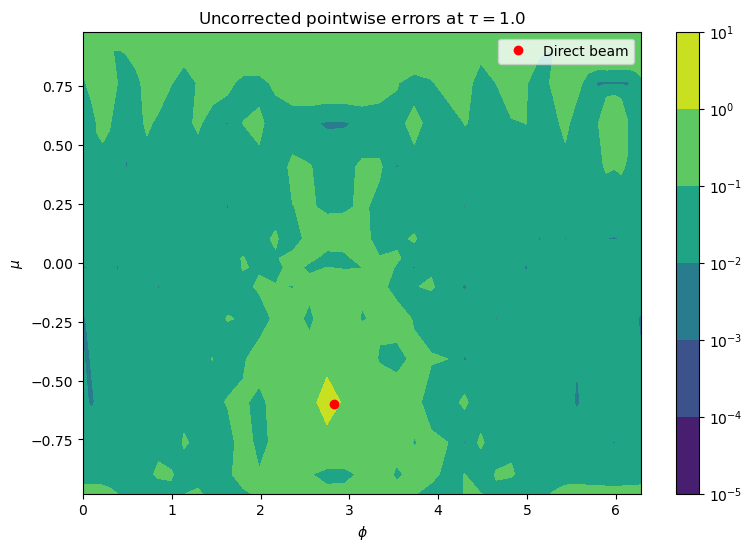

In [61]:
plot = error

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot, norm=mpl.colors.LogNorm())
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(r"Uncorrected pointwise errors at $\tau =$" + str(tau_pt))
plt.legend()

In [62]:
print("At tau = " + str(tau_pt))
print("Max pointwise error =", np.max(error))

At tau = 1.0
Max pointwise error = 1.5927400410151202


### 3.7.2 NT corrections

*This is implemented in* `disort.py`.

This subsection summarizes the main points from [[12]](#cite-NT1988) and from *Appendix A* of [[8]](#cite-STWLE2000) but omits most of the mathematical explanation. Recall that $\tau^*, \omega^*, p^*$ denote $\delta-M$ scaled parameters and $f$ is the scattering fraction into peak. Nakajima-Tanaka (NT) corrections are disabled by default, enable them with the flag `NT_cor = True`. Note that if $I_0 = 0$, $f = 0$ or only $\text{NLeg}$ coefficients are supplied in `Leg_coeffs_all`, then NT corrections will remain disabled.

The $\delta-M$ method allows for accurate flux computation, but intensity values remain inaccurate particularly at backscattering angles and around the direct beam. These inaccuracies are largely caused by truncation of the Legendre series of the phase function. Nakajima and Tanaka proposed intensity corrections to reduce these accuracies. This correction is applied to the intensity but not to the flux as the latter is already accurate. This unfortunately means that flux values calculated by integrating the corrected intensity will differ slightly from values given by the flux functions. Note that NT corrections ignore, or rather have not been derived for, the isotropic internal source $s$, see [[8, section 3.6.3]](#cite-STWLE2000), and they ignore surface reflection, see section [3.7.3](#3.7.3-Verification-and-visualization:-NT-corrected).

**TMS correction**

For the first of two NT corrections, named *TMS*, one approximates $u_\text{true} \approx u_\text{TMS} = u^* + \left(\tilde{u}_1^* - u_1^*\right)$. One has that $u_1^*$ and $\tilde{u}_1^*$ are true solutions to the single-scattering equations for

$$
\begin{aligned}
\mu \frac{\partial \tilde{u}_1^*(\tau^*, \mu, \phi)}{\partial \tau^*} &= \tilde{u}_1^*(\tau^*, \mu, \phi) -\frac{\omega^* I_0}{(1 - f) 4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right) \\
\mu \frac{\partial u_1^*(\tau^*, \mu, \phi)}{\partial \tau^*} &= u_1^*(\tau^*, \mu, \phi) -\frac{\omega^* I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)
\end{aligned}
$$

respectively. Note that by construction (section [1.3.1](#1.3.1-OPTIONAL:-Choose-delta-M-scaling)), $p^*$ has a finite number of (non-zero) Legendre coefficients. In contrast, $p$ is the original phase function and in general has infinite Legendre coefficients. Unlike the Henyey-Greenstein phase function, realistic phase functions derived from Mie equations generally only have series representations. This lack of a closed-form means that it is impossible to input the true $p$ into PythonicDISORT. Instead, a large (`NLeg_all`) number of Legendre coefficients is used to very accurately approximate $p$.

By superposition, every correction term, i.e. every term but $u^*$, must satisfy homogeneous BCs. This is not true when there is surface reflection but we will only discuss this complication in section [3.7.3](#3.7.3-Verification-and-visualization:-NT-corrected). The correction function $\left(\tilde{u}_1^* - u_1^*\right)$ can be analytically determined. The TMS correction to the solution is applied for each atmospheric layer. For $\mu > 0$ and $\tau \in [\tau_{l-1}, \tau_{l}]$, one has

$$
\begin{aligned}
\left(\tilde{u}_1^* - u_1^*\right)(\tau^*, \mu, \phi) &= \mathscr{B}_l(\mu, \phi)\left[\exp\left(-\frac{\tau^*}{\mu_0}\right) - \exp\left(\frac{\tau^* - \tau^*_{l}}{\mu} - \frac{\tau^*_{l}}{\mu_0}\right)\right] + \text{Contribution from layers below} \\
\left(\tilde{u}_1^* - u_1^*\right)(\tau^*, -\mu, \phi) &= \mathscr{B}_l(-\mu, \phi)\left[\exp\left(-\frac{\tau^*}{\mu_0}\right) - \exp\left(\frac{\tau^*_{l-1} - \tau^*}{\mu} - \frac{\tau^*_{l-1}}{\mu_0}\right)\right] + \text{Contribution from layers above}
\end{aligned}
$$

The contributions of layer $j$ to the layers above and below it are

$$
\begin{aligned}
&\mathscr{B}_j(\mu, \phi)\left[\exp\left(\frac{\tau^* - \tau^*_{j-1}}{\mu} - \frac{\tau^*_{j-1}}{\mu_0}\right) - \exp\left(\frac{\tau^* - \tau^*_j}{\mu} - \frac{\tau^*_j}{\mu_0}\right) \right] \\
&\mathscr{B}_j(-\mu, \phi)\left[ \exp\left(\frac{\tau^*_j - \tau^*}{\mu} - \frac{\tau^*_j}{\mu_0}\right) - \exp\left(\frac{ \tau^*_{j-1} - \tau^*}{\mu} - \frac{\tau^*_{j-1}}{\mu_0}\right)\right]
\end{aligned}
$$

respectively. The correction source terms give

$$
\mathscr{B}_l(\mu, \phi) = \left(\frac{\mu_0}{\mu_0 + \mu}\right) \frac{\omega^*_l I_0}{4 \pi} \left(\frac{p_l}{1-f} - p^*_l\right)\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right)
$$

Note the singularity if $\mu = -\mu_0$, i.e. $\mu_0$ coincides with a quadrature angle, in $\mathscr{B}_l$. This is a special case which we have not implemented.

**IMS correction**

The TMS correction substantially reduces the truncation error everywhere except around the direct beam. A second NT correction named *IMS* is required to address the significant errors that remain. One incorporates the IMS through the approximation $u_\text{true} \approx u_\text{TMS} + u_\text{IMS}$. It is impractical to determine $u_\text{IMS}$ exactly and both [[8]](#cite-STWLE2000) and [[12]](#cite-NT1988) make many approximations to determine $u_\text{IMS}$. Follow [[8]](#cite-STWLE2000) and approximate the IMS correction as

$$
\begin{aligned}
u_\text{IMS}(\tau, -\mu, \phi) \approx \frac{I_0}{4 \pi} \frac{\left(\bar{\omega} \bar{f}\right)^2}{1-\bar{\omega} \bar{f}}\left[2 p_r\left(-\mu, \phi ;-\mu_0, \phi_0\right)-p_r^2\left(-\mu, \phi ;-\mu_0, \phi_0\right)\right]\chi\left(\tau,-\mu,-\mu_0',-\mu_0'\right)
\end{aligned}
$$

for $\mu > 0$, and take $u_\text{IMS}(\tau, -\mu, \phi) \approx 0$ for $\mu \leq 0$, i.e. **the correction applies only to the downward intensities.** One has that $p_r = p - p^*$ is the residual phase function from the $\delta-M$ approximation (section [1.3.1](#1.3.1-OPTIONAL:-Choose-delta-M-scaling)) and

$$
p_r^2\left(-\mu, \phi ;-\mu_0, \phi_0\right) = \frac{1}{4 \pi} \int_0^{2 \pi} \int_{-1}^1 p_r\left(-\mu, \phi ; \mu', \phi'\right) p_r\left(\mu', \phi' ;-\mu_0, \phi_0\right) \mathrm{d} \phi' \mathrm{d} \mu'
$$

Using the series expansion for the residual phase function and the optical properties that are averaged over all atmospheric layers (explicit formulas given further below), one gets

$$
\begin{aligned}
u_\text{IMS}\approx \frac{I_0}{4 \pi} \frac{\left(\bar{\omega} \bar{f}\right)^2}{1-\bar{\omega} \bar{f}}\left[\sum_{\ell=0}^\infty (2\ell + 1) \left(2\bar{g}_\ell - \bar{g}_\ell^2\right)P_\ell(\nu)\right]\chi\left(\tau, -\mu, -\mu_0', -\mu_0'\right)
\end{aligned}
$$

As with $p$, truncate the series at `NLeg_all` and assume that the remaining Legendre terms are negligible.


Derive the function

$$
\begin{aligned}
&\chi\left(\tau, -\mu, -\mu', -\mu^{\prime \prime}\right) = \frac{\exp\left({-\tau \big/ \mu}\right)}{\mu \mu'} \int_0^\tau \exp\left(\frac{t}{\mu} - \frac{t}{\mu'}\right) \left(\int_0^t \exp\left(\frac{t'}{\mu'} - \frac{t'}{\mu^{\prime \prime}}\right) \mathrm{d} t' \right)\mathrm{d} t \\
&\implies \chi\left(\tau, -\mu, -\mu_0', -\mu_0'\right) = \frac{1}{x\mu\mu'_0}\left[\left(\tau-\frac{1}{x}\right) \exp\left(-\frac{\tau}{\mu_0'}\right)+\frac{\exp\left(-\tau\big/\mu\right)}{x}\right], \quad x = \frac{1}{\mu}-\frac{1}{\mu_0'}
\end{aligned}
$$

which is further detailed in [[8]](#cite-STWLE2000). Since there are cases in which $\mu_0 = \mu_0'$, we do not allow $\mu_0$ to coincide with a quadrature angle (see section [1.4](#1.4-Choose-direct-beam-source)) to avoid singularities due to $x = 0$. Singularities may still arise but are very unlikely given this precaution. Dithering can prevent singularities altogether but we have not implemented it. 

Finally, one gets from [[8]](#cite-STWLE2000) the optical values that are averaged over all atmospheric layers and a scaled $\mu_0$:

$$
\begin{aligned}
\bar{\omega}&=\sum_{l=1}^L \omega_l \tau_l \bigg/ \sum_{l=1}^L \tau_l \\
\bar{f}&=\sum_{l=1}^L f_l \omega_l \tau_l \bigg/ \sum_{l=1}^L \omega_l \tau_l \\
\bar{g}_{\ell}&=\sum_{l=1}^L g_{l, \ell}^r \omega_l \tau_l \bigg/ \sum_{l=1}^L f_l \omega_l \tau_l \\
g_{l, \ell}^r &= 
\begin{cases} f_l, &\ell \leq \text{NLeg} \\
g_{l, \ell}, &\ell > \text{NLeg} \end{cases} \\
\mu_0' &= \frac{\mu_0} {1-\bar{\omega} \bar{f}}
\end{aligned}
$$

### 3.7.3 Verification and visualization: NT corrected

We include the (Lambertian) BDRF and (isotropic) BCs.

In [63]:
# Include the (Lambertian) BDRF and (isotropic) BCs

# With delta-M scaling but without NT corrections
u_dM = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    BDRF_Fourier_modes=BDRF_Fourier_modes,
    b_pos=b_pos,
    b_neg=b_neg,
    f_arr=f_arr[0],
    autograd_compatible=True,
)[-1]

# With both delta-M scaling and NT corrections
u_NT = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    BDRF_Fourier_modes=BDRF_Fourier_modes,
    b_pos=b_pos,
    b_neg=b_neg,
    f_arr=f_arr[0],
    NT_cor=True,
    autograd_compatible=True,
)[-1]

**Does the full solution satisfy the BCs?**

If there is no surface reflection the NT corrected full solution would satisfy the BCs. If there is surface reflection, however, one would have had corrected the intensity without correcting the reflected intensity. Consequently, the BC at BoA would no longer be satisfied. Observe that the error in the BC is small, at least for current parameters, and so we will simply ignore it. This is also the choice Stamnes et. al. make in DISORT2, see [[8, section 3.6.3]](#cite-STWLE2000). In DISORT3, they account for the BDRF when solving for the TMS / single-scattering correction but not for the IMS correction, see [[9, section 3.5.2]](#cite-LSJLTWS2015).

The BC at ToA remains satisfied:

In [64]:
# At top of atmosphere
assert np.allclose(
    u_NT(0, phi_arr)[N:, :],
    b_neg_test @ np.cos(np.arange(NFourier)[:, None] * (phi0 - phi_arr)),
)

print("Passed all tests")

Passed all tests


The BC at BoA, on the other hand, is not satisfied because the surface reflection was not corrected, though the error is small:

In [65]:
BDRF_contribution_NT = np.einsum(
    "ijkl, kl, k, l -> ij",
    BDRF(mu_arr_pos, phi_arr, -mu_arr_pos, phi_arr),
    mu_arr_pos[:, None] * u_NT(tau_arr[-1], phi_arr)[N:, :],
    W,
    full_weights_phi,
    optimize=True,
) / pi + (I0 * mu0) / pi * np.exp(-scaled_tau_arr_with_0[-1] / mu0) * BDRF(
    mu_arr_pos, phi_arr, -mu0, phi0
)
BC_Error = np.abs(
    u_NT(tau_arr[-1], phi_arr)[:N, :]
    - (
        b_pos_test @ np.cos(np.arange(NFourier)[:, None] * (phi0 - phi_arr))
        + BDRF_contribution_NT
    )
)

print("The BC at BoA is satisfied:", np.allclose(BC_Error, 0))
print(
    "Max pointwise error =",
    np.max(BC_Error),
)

The BC at BoA is satisfied: False
Max pointwise error = 4.3193048782086407e-07


**Does the full solution satisfy the radiative transfer equation?**

In [66]:
# Plots will be created for only this value of tau
tau_pt = 1.  # Must be a float for auto-differentiation to work

In [67]:
LHS_NT = (
    mu_arr_RO[:, None]
    * ag.jacobian(lambda tau: u_NT(tau, phi_arr))(tau_pt)[reorder_mu, :]
)
RHS_NT = (
    u_NT(tau_pt, phi_arr)[reorder_mu]
    - (omega_l / (4 * pi))
    * np.einsum(
        "ijkl, kl, k, l -> ij",
        p_HG_muphi(mu_arr_RO, phi_arr, mu_arr_RO, phi_arr),
        u_NT(tau_pt, phi_arr)[reorder_mu],
        full_weights_mu_RO,
        full_weights_phi,
        optimize=True,
    )
    - (omega_l * I0 / (4 * pi))
    * p_HG_muphi(mu_arr_RO, phi_arr, -mu0, phi0)
    * np.exp(-tau_pt / mu0)
)
error_NT = np.abs(RHS_NT - LHS_NT)

Similar to the verification in section [3.6.3](#3.6.3-Verification-of-the-general-solution), this verification will not reflect quadrature and truncation errors.

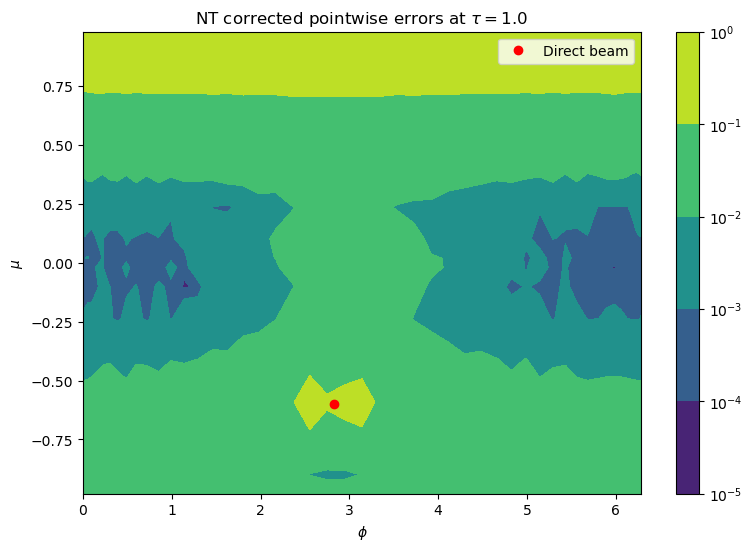

In [68]:
plot = error_NT

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot, norm=mpl.colors.LogNorm())
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(r"NT corrected pointwise errors at $\tau =$" + str(tau_pt))
plt.legend()

In [69]:
print("At tau = " + str(tau_pt))
print("Max pointwise error =", np.max(error_NT))

At tau = 1.0
Max pointwise error = 0.22460299464498235


## 3.8 Computation of flux

*This is implemented in* `_assemble_intensity_and_fluxes.py`.

PythonicDISORT also returns the positive (upward) and negative (downward) (energetic) flux functions. One has that

$$
F_\text{total}^\pm(\tau) = F_\text{diffuse}^\pm(\tau) + F_\text{direct}^\pm(\tau)
$$


**Direct (beam) flux**

Since the direct beam is

$$u_\text{direct}(\tau, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)$$

and $\mu_0 > 0$, one has 

$$F_\text{direct}^+(\tau) \equiv 0, \quad F_\text{direct}^-(\tau) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

**Diffuse flux**

The diffuse flux equals

$$
\begin{aligned}
F_\text{diffuse}^\pm(\tau) &= \int_{0}^{1} \int_{0}^{2 \pi} \mu u\left(\tau, \pm\mu, \phi\right) \mathrm{d} \phi \mathrm{d} \mu \\
&= \sum_{m=0}^\infty \left(\int_{0}^{1} \mu u^m(\tau, \pm\mu) \mathrm{d} \mu \int_{0}^{2 \pi} \cos\left(m\left(\phi_0 - \phi\right)\right) \mathrm{d} \phi \right) \\
&= 2\pi \int_{0}^{1} \mu u^0\left(\tau, \pm\mu\right) \mathrm{d} \mu \\
&\approx 2\pi \sum_{i = 1}^N w_i\mu_i u^0\left(\tau, \pm\mu_i\right)
\end{aligned}
$$

using the Fourier expansion of $u$ from section [3.2](#3.2-Fourier-expansion-of-solution). In the last line, the $\mu$ integral can be approximated by Gauss-Legendre quadrature. Only the $0$th moment matters for the flux. Pass `is_antiderivative_wrt_tau=True` to switch to an antiderivative of the function with respect to `tau`. The upwelling and downwelling are respectively 

$$F_\text{total}^+(0), \quad F_\text{total}^-(\tau_\text{BoA})$$ 

### 3.8.1 Impact of delta-M scaling on flux calculations

When one performs $\delta-M$ scaling one artificially augments the direct beam at the expense of the diffuse radiation. If one only cared about the total upward and downward flux, then the calculations will be identical to above. If one wishes to distinguish between direct and diffuse fluxes like in Stamnes' DISORT [[9]](#cite-LSJLTWS2015), then one will need to exercise more caution. The direct fluxes must be

$$F_\text{direct}^+(\tau) \equiv 0, \quad F_\text{direct}^-(\tau) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

With $\delta-M$ scaling, however, one gets a larger value for the downward direct flux since the direct beam was augmented, i.e.

$$F_\text{direct}^-(\tau^*) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau^*\right) > I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right) = F_\text{direct}^-(\tau)$$

Therefore, one will need to reclassify the additional downward flux

$$I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau^*\right) - I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

 from direct to diffuse, as is done in Stamnes' DISORT and PythonicDISORT.

### 3.8.2 Verification of flux

**Does integrating the intensity functions produce the flux functions?**

This test may fail if NT corrections are enabled, i.e. `NT_cor = True`, because the corrections are only applied to the intensity and not the fluxes.

In [70]:
Ntau = 100 # Number of tau test points
tau_test_arr = np.random.random(Ntau) * tau_arr[-1]

# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1  
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)

In [71]:
# No NT corrections or delta scaling but includes (isotropic) BCs
flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
)[1:]
u_cache = u(tau_test_arr, phi_arr)

In [72]:
flux_up_test = np.einsum(
    "itp, i, p -> t",
    mu_arr_pos[:, None, None] * u_cache[:N, :],
    W,
    full_weights_phi,
    optimize=True,
)
flux_down_test = np.einsum(
    "itp, i, p -> t",
    mu_arr_pos[:, None, None] * u_cache[N:, :],
    W,
    full_weights_phi,
    optimize=True,
)

In [73]:
print("Flux up")
print(
    "Max pointwise error =",
     np.max(np.abs(flux_up(tau_test_arr) - flux_up_test)),
)
print()
print("Flux down (diffuse only)")
print(
    "Max pointwise error =",
    np.max(np.abs(flux_down(tau_test_arr)[0] - flux_down_test)),
)

Flux up
Max pointwise error = 1.659117287999834e-09

Flux down (diffuse only)
Max pointwise error = 7.3872215011761e-09


**Does** $\delta-M$ **scaling result in more accurate fluxes?**

We increase $g$ to $0.9$ to make the phase function more anisotropic to better demonstrate the effect of $\delta-M$ scaling.

In [74]:
g_dM = 0.9
Leg_coeffs_all_dM = g_dM ** np.arange(128)
f = Leg_coeffs_all_dM[NLeg]

In [75]:
# Fluxes without delta-scaling
flux_up, flux_down = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0], 
    NQuad, 
    Leg_coeffs_all_dM,
    mu0, I0, phi0, 
    only_flux=True
)[1:3]

# Fluxes with delta-scaling
flux_up_dS, flux_down_dS = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all_dM,
    mu0, I0, phi0,
    only_flux=True,
    f_arr=f,
)[1:3]

# Fluxes calculated using large NQuad and NLeg
# (we take this as the "true" solution against which to measure error)
flux_up_true, flux_down_true = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0], 
    128, 
    Leg_coeffs_all_dM, 
    mu0, I0, phi0, 
    only_flux=True,
    f_arr=f,
)[1:3]

In [76]:
print("Without delta-scaling, i.e. f =", 0)
print(
    "Flux up: Max pointwise error =",
    np.max(np.abs(flux_up(tau_test_arr) - flux_up_true(tau_test_arr))),
)
print(
    "Flux down: Max pointwise error =",
    np.max(
        np.abs(
            np.sum(flux_down(tau_test_arr), axis=0)
            - np.sum(flux_down_true(tau_test_arr), axis=0)
        ),
    ),
)
print()

print("With delta-scaling, f =", f)
print(
    "Flux up: Max pointwise error =",
    np.max(np.abs(flux_up_dS(tau_test_arr) - flux_up_true(tau_test_arr))),
)
print(
    "Flux down: Max pointwise error =",
    np.max(
        np.abs(
            np.sum(flux_down_dS(tau_test_arr), axis=0)
            - np.sum(flux_down_true(tau_test_arr), axis=0)
        ),
    ),
)

Without delta-scaling, i.e. f = 0
Flux up: Max pointwise error = 0.016172907353617205
Flux down: Max pointwise error = 0.018021456296480665

With delta-scaling, f = 0.18530201888518416
Flux up: Max pointwise error = 0.001995227317436843
Flux down: Max pointwise error = 0.0018907105643179989


### 3.8.3 Reflectance and transmittance

**Incident flux**

In order to compute the reflectance and transmittance, one will first need to determine the incident flux at each boundary. This includes both the direct flux from the direct beam at $\tau = 0$, which equals $I_0 \mu_0$ (see section [3.8](#3.8-Computation-of-flux)), and flux from the boundary conditions.

Focusing on the BCs, recall from section [1.6](#1.6-OPTIONAL:-Choose-boundary-sources) that they are

$$
u\left(\tau_\text{BoA}, \mu_i, \phi \right) = \sum_{m = 0}^{\text{NFourier}}b^+_{im}\cos(m(\phi_0 - \phi)), \quad u(0, -\mu_i, \phi) = \sum_{m = 0}^{\text{NFourier}}b^-_{im}\cos(m(\phi_0 - \phi)) \quad i = 1, \dots, N
$$

The incident flux from the BCs, which we denote $F_{b^\pm}$, are

$$F_{b^\pm} = 2 \pi \sum_{i = 0}^N w_i \mu_i b^\pm_{i0}$$

respectively, where $w_i$ are quadrature weights.  Once again, only the $0$th moment matters for the flux. If the BCs are constant over $\mu$, this simplifies to

$$F_{b^\pm} = \pi b^\pm$$

**Computation and interpretation of reflectance, transmittance and absorption**

Reflectance, $\mathscr{R}$, and transmittance, $\mathscr{T}$, can be computed only if the incident radiation comes entirely from one side of the atmosphere, usually downward onto the top layer. Generally, reflectance and transmittance are computed first, then absorptance $\mathscr{A}$ is calculated from the fact that the three ratios must sum to $1$ with respect to a specific source. As an example, we will calculate the reflectance, transmittance and absorptance with respect to the direct beam:

$$
\mathscr{R} = \frac{F_\text{Total}^+(0)}{I_0 \mu_0}, \quad \mathscr{T} = \frac{F_\text{Total}^-(\tau_0)}{I_0 \mu_0}, \quad \mathscr{A} = 1 - \mathscr{R} - \mathscr{T}
$$

which requires us to set the BCs $b^\pm = 0$.

In [77]:
# Example calculation
flux_up, flux_down = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0], 
    NQuad, 
    Leg_coeffs_all[-1, :],
    mu0, I0, phi0, 
    only_flux=True
)[1:3]

Ref = flux_up(0) / (I0 * mu0)
Trans = np.sum(flux_down(tau_arr[-1]), axis=0) / (I0 * mu0)

print("Reflectance =", Ref)
print("Transmittance =", Trans)
print("Absorptance =", 1 - Ref - Trans)

Reflectance = 0.6295114215914739
Transmittance = 0.3704723849867811
Absorptance = 1.619342174502547e-05


# 4. Solve for multiple layers

*This is implemented in* `_solve_for_coeffs.py`.

If the atmosphere has multiple layers, they will be coupled through their BCs as the solution must be continuous in $\tau$. Notice that the BCs are only used to solve for the coefficients of the homogeneous solution. Hence, the process is to solve for the general solution of each layer up to unknown coefficients then solve for all unknown coefficients simultaneously through a generalization of section [3.6.2](#3.6.2-The-homogeneous-solution). The "full solution" for each layer is constructed as per section [3.7](#3.7-The-full-solution). The full solution for the entire multi-layer atmosphere branches to the "full solution" of individual layers depending on the $\tau$ input.

**Multi-layer generalization of section** [3.6.2](#3.6.2-The-homogeneous-solution)

We have $\text{NLayers} = L + 1$ layers demarcated by $[0, \tau_0], [\tau_0, \tau_1], [\tau_1, \tau_2], \dots, [\tau_{L-1}, \tau_L]$ with $\tau_L = \tau_\text{BoA}$. Denote $\mathscr{E}_i = \exp\left(-\mu_0^{-1} \tau_i\right)$. The BCs are

$$
\begin{aligned}
&v^-(0) &&= b^-_m - B_0^- - \delta_{0m}\mathscr{v}^-_0(0) \\ 
v^+\left( \tau_{L} \right) - R&v^-\left(\tau_{L}\right) &&=  b^+_m + \left(\mathscr{X} + RB_L^- - B_L^+\right)\mathscr{E}_L + \delta_{0m}(R\mathscr{v}^-(\tau_{L}) - \mathscr{v}^+(\tau_{L}))
\end{aligned}
$$

Since the full solution is continuous in $\tau$ but the particular solutions are not,

$$
\begin{aligned}
&v_0^-\left(\tau_0\right) + B_0^-\mathscr{E}_0 + \delta_{0m}\mathscr{v}^-_0(\tau_0) = v_1^-\left(\tau_0\right) + B_1^-\mathscr{E}_0 + \delta_{0m}\mathscr{v}^-_1(\tau_0) &&v_0^+\left(\tau_0\right) + B_0^+\mathscr{E}_0 + \delta_{0m}\mathscr{v}^+_0(\tau_0) = v_1^+\left(\tau_0\right) + B_1^+\mathscr{E}_0 + \delta_{0m}\mathscr{v}^+_1(\tau_0) \\
&v_1^-\left(\tau_1\right) + B_1^-\mathscr{E}_1 + \delta_{0m}\mathscr{v}^-_1(\tau_1) = v_2^-\left(\tau_1\right) + B_2^-\mathscr{E}_1 + \delta_{0m}\mathscr{v}^-_2(\tau_1) &&v_1^+\left(\tau_1\right) + B_1^+\mathscr{E}_1 + \delta_{0m}\mathscr{v}^+_1(\tau_1) = v_2^+\left(\tau_1\right) + B_2^+\mathscr{E}_1 + \delta_{0m}\mathscr{v}^+_2(\tau_1) \\
&\quad \vdots &&\quad \vdots\\
&v_{L-1}^-\left(\tau_{L-1}\right) + B_{L-1}^-\mathscr{E}_{L-1} + \delta_{0m}\mathscr{v}^-_{L-1}(\tau_{L-1}) &&v_{L-1}^+\left(\tau_{L-1}\right) + B_{L-1}^+\mathscr{E}_{L-1} + \delta_{0m}\mathscr{v}^+_{L-1}(\tau_{L-1}) \\
&= v_{L}^-\left(\tau_{L-1}\right) + B_{L}^-\mathscr{E}_{L-1} + \delta_{0m}\mathscr{v}^-_{L}(\tau_{L-1}) &&  = v_{L}^+\left(\tau_{L-1}\right) + B_{L}^+\mathscr{E}_{L-1} + \delta_{0m}\mathscr{v}^+_{L}(\tau_{L-1})
\end{aligned}
$$

Denote $E_{i} = E_l(\tau_i)$, where $E_l(\tau_i)$ is a diagonal matrix with $\exp(k_{lj}\tau_i)$ as diagonal entry $j$. We omit the index $l$ of $E_l(\tau_i)$ because it will always match the index of the accompanying eigenvector matrix $G_l$, which will in turn match the index of the coefficient vector $\xi_l$. The BCs produce a system with

$$
\begin{aligned}
\text{LHS} &= \begin{bmatrix} 
G^-_0 & 0 & 0 & & 0 & 0 \\ 
G^+_0 E_{0} & -G^+_1 E_{0} & 0 & & 0 & 0 \\ 
G^-_0 E_{0} & -G^-_1 E_{0} & 0 & & 0 & 0 \\ 
0 & G^+_1 E_{1} & -G^+_2 E_{1} & & 0 & 0 \\ 
0 & G^-_1 E_{1} & -G^-_2 E_{1} & & 0 & 0 \\
& & & \ddots & & \\
0 & 0 & 0 & & G^+_{L-1} E_{L-1} & -G^+_L E_{L-1} \\ 
0 & 0 & 0 & & G^-_{L-1} E_{L-1} & -G^-_L E_{L-1} \\
0 & 0 & 0 & & 0 & \left(G^+_L - RG^-_L\right) E_L
\end{bmatrix} 
\begin{bmatrix} 
\xi_0 \\ 
\xi_1 \\ 
\xi_2 \\ 
\vdots \\
\xi_{L-1} \\
\xi_L 
\end{bmatrix} \\
\text{RHS} &= \begin{bmatrix} b^-_m - B_0^- - \delta_{0m}\mathscr{v}^-_0(0) \\ 
\left(B^+_1 - B^+_0\right)\mathscr{E}_0 + \delta_{0m}\left(\mathscr{v}^+_1 - \mathscr{v}^+_0\right)(\tau_0)  \\
\left(B^-_1 - B^-_0\right)\mathscr{E}_0 + \delta_{0m}\left(\mathscr{v}^-_1 - \mathscr{v}^-_0\right)(\tau_0) \\ 
\left(B^+_2 - B^+_1\right)\mathscr{E}_1 + \delta_{0m}\left(\mathscr{v}^+_2 - \mathscr{v}^+_1\right)(\tau_1) \\
\left(B^-_2 - B^-_1\right)\mathscr{E}_1 + \delta_{0m}\left(\mathscr{v}^-_2 - \mathscr{v}^-_1\right)(\tau_1)\\ 
\vdots \\
\left(B^+_{L} - B^+_{L-1}\right)\mathscr{E}_{L-1} + \delta_{0m}\left(\mathscr{v}^+_{L} - \mathscr{v}^+_{L-1}\right)(\tau_{L-1}) \\ 
\left(B^-_{L} - B^-_{L-1}\right)\mathscr{E}_{L-1} + \delta_{0m}\left(\mathscr{v}^-_{L} - \mathscr{v}^-_{L-1}\right)(\tau_{L-1}) \\ 
b^+_m + \left(\mathscr{X} + RB_L^- - B_L^+\right)\mathscr{E}_L + \delta_{0m}(R\mathscr{v}^-(\tau_{L}) - \mathscr{v}^+(\tau_{L}))
\end{bmatrix}
\end{aligned}
$$

As in section [3.6.2](#3.6.2-The-homogeneous-solution), we have additional superscripts $+$ and $-$ to denote only positive or only negative eigenvalues respectively. The multi-layer Stamnes-Conklin's substitutions [[4]](#cite-SC1984) are 

$$
\begin{aligned}
&\xi_0^- = C_0^- &&\xi_0^+ = E^-_0 C_0^+ \\
&\xi_1^- = E^+_0 C_1^- &&\xi_1^+ = E^-_1 C_1^+ \\
&\quad \vdots &&\quad \vdots \\
&\xi_L^- = E^+_{L-1} C_L^- && \xi_L^+ = E^-_L C_L^+
\end{aligned}
$$

Recall that the eigenvalues are arranged negative then positive, e.g. $G^+_1 E_1 = \begin{bmatrix} G^{+-}_1 E^-_1 & G^{++}_1 E^+_1 \end{bmatrix}$. Denote $E_{ij} = E^+_iE^-_j$. Every entry of $E_{ij}$ will have a negative exponent if $i < j$. After substitutions the LHS becomes

$$
\begin{bmatrix} 
G^{--}_0 & G^{-+}_0 E^-_0 & 0 & 0 & & 0 & 0 & 0 & 0 \\ 
G^{+-}_0 E^-_0 & G^{++}_0 & -G^{+-}_1 & -G^{++}_1 E_{01} & & 0 & 0 & 0 & 0 \\ 
G^{--}_0 E^-_0 & G^{-+}_0 & -G^{--}_1 & -G^{-+}_1 E_{01} & & 0 & 0 & 0 & 0 \\ 
& & & & \ddots & & & & \\
0 & 0 & 0 & 0 & & G^{+-}_{L-1} E_{L-2,\,L-1} & G^{++}_{L-1} & -G^{+-}_{L} & -G^{++}_{L}E_{L-1,\,L} \\ 
0 & 0 & 0 & 0 & & G^{--}_{L-1} E_{L-2,\,L-1} & G^{-+}_{L-1} & -G^{--}_{L} & -G^{-+}_{L}E_{L-1,\,L} \\
0 & 0 & 0 & 0 & & 0 & 0 & \left(G^+_L - RG^-_L\right)^-E_{L-1,\,L} & \left(G^+_L - RG^-_L\right)^+
\end{bmatrix} 
\begin{bmatrix} 
C^-_0 \\ 
C^+_0 \\ 
C^-_1 \\ 
C^+_1 \\ 
\vdots \\
C^-_{L-1} \\
C^+_{L-1} \\
C^-_L \\
C^+_L \\
\end{bmatrix} 
$$

while the RHS remains the same. This system will always be well-conditioned as the LHS converges to a block diagonal matrix when $\tau \rightarrow \infty$.

**Sparsity of the LHS matrix**

If the atmosphere has at least three layers, the LHS matrix becomes a $6N - 1$ band matrix with a density of

$$\frac{4N^2(2L + 1)}{(2N(L + 1))^2} = \frac{2L + 1}{(L + 1)^2}$$

It gets sparser as the number of layers increases. We recommend using `scipy.linalg.solve_banded` if the density of the matrix is less than $0.2$ or equivalently when $L \geq 9 \iff \text{NLayers} \geq 10$ but users may choose their own threshold using the `use_banded_solver_NLayers` argument in `pydisort`, see section [1.2](#1.2-Choose-computational-parameters).

**Example assembly of LHS matrix**

In [78]:
G_collect_m = np.random.random((NLayers, NQuad, NQuad))
K_collect_m = np.random.random((NLayers, NQuad))

In [79]:
# Assemble LHS
dim = NLayers * NQuad
LHS = np.zeros((dim, dim))

G_0_nn = G_collect_m[0, N:, :N]
G_0_np = G_collect_m[0, N:, N:]
E_01 = np.exp(K_collect_m[0, :N] * scaled_tau_arr_with_0[1])

G_L_pn = G_collect_m[-1, :N, :N]
G_L_nn = G_collect_m[-1, N:, :N]
G_L_pp = G_collect_m[-1, :N, N:]
G_L_np = G_collect_m[-1, N:, N:]
E_Lm1L = np.exp(
    K_collect_m[-1, :N] * (scaled_tau_arr_with_0[-1] - scaled_tau_arr_with_0[-2])
)
if m < NBDRF:
    BDRF_LHS_contribution_neg = R @ G_L_nn
    BDRF_LHS_contribution_pos = R @ G_L_np
else:
    BDRF_LHS_contribution_neg = 0
    BDRF_LHS_contribution_pos = 0

# BCs for the entire atmosphere
# ---------------- Top BC ----------------
LHS[:N, :N] = G_0_nn
LHS[:N, N : 2 * N] = G_0_np * E_01[None, :]
# ---------------- Bottom BC ----------------
LHS[-N:, -2 * N : -N] = (G_L_pn - BDRF_LHS_contribution_neg) * E_Lm1L[None, :]
LHS[-N:, -N:] = G_L_pp - BDRF_LHS_contribution_pos

# Interlayer / continuity BCs
for l in range(NLayers - 1):
    G_l_pn = G_collect_m[l, :N, :N]
    G_l_nn = G_collect_m[l, N:, :N]
    G_l_ap = G_collect_m[l, :, N:]
    
    G_lp1_an = G_collect_m[l + 1, :, :N]
    G_lp1_pp = G_collect_m[l + 1, :N, N:]
    G_lp1_np = G_collect_m[l + 1, N:, N:]
    
    scaled_tau_arr_lm1 = scaled_tau_arr_with_0[l]
    scaled_tau_arr_l = scaled_tau_arr_with_0[l + 1]
    scaled_tau_arr_lp1 = scaled_tau_arr_with_0[l + 2]
    
    # Postive eigenvalues
    E_lm1l = np.exp(K_collect_m[l, N:] * (scaled_tau_arr_lm1 - scaled_tau_arr_l))
    E_llp1 = np.exp(K_collect_m[l + 1, N:] * (scaled_tau_arr_l - scaled_tau_arr_lp1))

    start_row = N + l * 2 * N
    start_col = l * 2 * N
    
    LHS[start_row : N + start_row, start_col : N + start_col] = G_l_pn * E_lm1l[None, :]
    LHS[N + start_row : 2 * N + start_row, start_col : N + start_col] = G_l_nn * E_lm1l[None, :]
    LHS[start_row : 2 * N + start_row, N + start_col : 2 * N + start_col] = G_l_ap
    
    LHS[start_row : 2 * N + start_row, 2 * N + start_col : 3 * N + start_col] = -G_lp1_an
    LHS[start_row : N + start_row, 3 * N + start_col : 4 * N + start_col] = -G_lp1_pp * E_llp1[None, :]
    LHS[N + start_row : 2 * N + start_row, 3 * N + start_col : 4 * N + start_col] = -G_lp1_np * E_llp1[None, :]

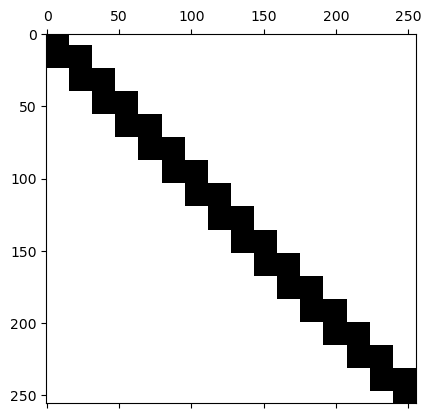

In [80]:
#%matplotlib ipympl

plt.spy(LHS)

**Regarding memory usage and potential improvements**

PythonicDISORT has been optimized for speed over memory usage. The output functions store multiple tensors, the largest of which has dimensions $\text{NFourier} \times \text{NLayers} \times \text{NQuad} \times \text{NQuad}$. When $u$ is called, a tensor of dimensions $\text{NFourier} \times \text{Ntau} \times \text{NQuad} \times \text{NQuad}$ is constructed, where $\text{Ntau}$ is the length of the $\tau$ input and is in general large. A more memory efficient method would be to input the $\tau$ and $\phi$ values into `pydisort` and have the output be the solution evaluated at those values rather than a function. This is how Stamnes' DISORT works [[1]](#cite-STWJ1988). That way, the largest tensor required will have dimensions $\text{Ntau} \times \text{NQuad} \times \text{NQuad}$, but the tradeoff will be less speed and flexibility. Even within our current design paradigm there are avenues for memory optimization. Depending on the phase function of each atmospheric layer, the $\text{NFourier} \times \text{NLayers} \times \text{NQuad} \times \text{NQuad}$ tensor may be sparse. Therefore, it may be beneficial to implement a sparse tensor framework or otherwise memory efficient variants of PythonicDISORT.

## 4.1 Verification of multi-layer solver

**When a single-layer atmosphere is broken into multiple homogeneous layers is the solution the same?**

In [81]:
Ntau = 100

tau_test_arr = np.sort(np.random.random(Ntau) * tau_arr[-1])

In [82]:
# Turn everything on
flux_up_1layer, flux_down_1layer, u0, u_1layer = PythonicDISORT.pydisort(
    tau_arr[-1], 0.8,  # Single-scattering albedo reduced to 0.8 
                       # so that blackbody emission is significant
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, 1, phi0,
    b_pos=1,
    b_neg=1,
    f_arr=f_arr[0],
    s_poly_coeffs=np.array([1, 1]),
    NT_cor=True,
)[1:]

flux_up_16layers, flux_down_16layers, u0, u_16layers = PythonicDISORT.pydisort(
    tau_arr, np.full(NLayers, 0.8),
    NQuad,
    Leg_coeffs_all,
    mu0, 1, phi0,
    b_pos=1,
    b_neg=1,
    f_arr=f_arr,
    s_poly_coeffs=np.tile(np.array([1, 1]), (NLayers, 1)),
    NT_cor=True,
)[1:]

In [83]:
assert np.allclose(flux_up_1layer(tau_test_arr), flux_up_16layers(tau_test_arr))
assert np.allclose(flux_down_1layer(tau_test_arr), flux_down_16layers(tau_test_arr))
assert np.allclose(u_1layer(tau_test_arr, phi_arr), u_16layers(tau_test_arr, phi_arr))

print("Passed all tests")

Passed all tests


# 5. Timing PythonicDISORT

The time taken is dependent on hardware and on input parameters, but this section should give a sense of the speed of PythonicDISORT. PythonicDISORT was timed on a personal laptop and the parameters that affect its speed the most are

In [84]:
print("NQuad, NLeg, NFourier, NLayers =", NQuad, NLeg, NFourier, NLayers)

NQuad, NLeg, NFourier, NLayers = 16 16 16 16


**Time taken to solve the radiative transfer equation (for a multi-layer atmosphere)**

The default configuration in these tests is direct beam source with $\text{NLayers}$ atmospheric layers.

In [85]:
print("Intensity")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0)
print()

print("Intensity with only one layer")
%timeit PythonicDISORT.pydisort(tau_arr[-1], omega_arr[0], NQuad, Leg_coeffs_all[0, :], mu0, I0, phi0)
print()

print("Intensity with blackbody emission and Lambertian BDRF")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0, s_poly_coeffs=s_poly_coeffs, BDRF_Fourier_modes=BDRF_Fourier_modes)
print()

print("Only fluxes")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0, only_flux=True)
print()

print("Only fluxes with delta-M scaling")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0, only_flux=True, f_arr=f_arr)

Intensity
82 ms ± 4.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Intensity with only one layer
7.03 ms ± 325 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Intensity with blackbody emission and Lambertian BDRF
84.5 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Only fluxes
7 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Only fluxes with delta-M scaling
7.47 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Time taken to evaluate the solution at just one point**

In [86]:
# Setup
flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
)[1:]

u_1 = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
)[-1]

u_NT = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=True,
)[-1]

u_NT_1 = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    f_arr=f_arr[0],
    NT_cor=True,
)[-1]

u_iso = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, 0, phi0,
    s_poly_coeffs=s_poly_coeffs,
)[-1]

Ntau_time = 1000
Nphi_time = 100
tau_test_arr_time = np.sort(np.random.random(Ntau_time) * tau_arr[-1])
phi_arr_time = np.random.random(Nphi_time) * 2 * pi

In [87]:
print("Intensity")
%timeit u(tau_test_arr_time[Ntau_time//2], phi_arr_time[Nphi_time//2])
print()

print("Intensity with only one layer")
%timeit u_1(tau_test_arr_time[Ntau_time//2], phi_arr_time[Nphi_time//2])
print()

print("Intensity with NT corrections")
%timeit u_NT(tau_test_arr_time[Ntau_time//2], phi_arr_time[Nphi_time//2])
print()

print("Intensity with NT corrections and only one layer")
%timeit u_NT_1(tau_test_arr_time[Ntau_time//2], phi_arr_time[Nphi_time//2])
print()

print("Intensity with only blackbody emission")
%timeit u_iso(tau_test_arr_time[Ntau_time//2], phi_arr_time[Nphi_time//2])
print()

print("Up and down fluxes respectively")
%timeit flux_up(0)
%timeit flux_down(tau_arr[-1])

Intensity
329 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Intensity with only one layer
336 µs ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Intensity with NT corrections
2.9 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Intensity with NT corrections and only one layer
2.51 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Intensity with only blackbody emission
623 µs ± 24 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Up and down fluxes respectively
170 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
195 µs ± 8.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Time taken to evaluate the solution at a large number of points**

In [88]:
print("Number of tau points =", Ntau_time, ", Number of phi points =", Nphi_time)
print()

print("Intensity")
%timeit u(tau_test_arr_time, phi_arr_time)
print()

print("Intensity with only one layer")
%timeit u_1(tau_test_arr_time, phi_arr_time)
print()

print("Intensity with NT corrections")
%timeit u_NT(tau_test_arr_time, phi_arr_time)
print()

print("Intensity with NT corrections and only one layer")
%timeit u_NT_1(tau_test_arr_time, phi_arr_time)
print()

print("Intensity with only blackbody emission")
%timeit u_iso(tau_test_arr_time, phi_arr_time)
print()

print("Up and down fluxes respectively")
%timeit flux_up(tau_test_arr_time)
%timeit flux_down(tau_test_arr_time)

Number of tau points = 1000 , Number of phi points = 100

Intensity
159 ms ± 6.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Intensity with only one layer
160 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Intensity with NT corrections
239 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Intensity with NT corrections and only one layer
182 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Intensity with only blackbody emission
148 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Up and down fluxes respectively
849 µs ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
913 µs ± 28 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


See section [6.5](#6.5-Timing-Stamnes'-DISORT) for the runtimes of a Python-wrapped Stamnes' FORTRAN DISORT [[3]](#cite-Sta1999) for comparison. There are three factors which significantly slow PythonicDISORT down relative to Stamnes' DISORT. First, Python inherently has more overhead than FORTRAN. This cannot be helped. Second, PythonicDISORT has for-loops over the atmospheric layers $l$ and over the Fourier modes $m$. We have removed as many for-loops as possible and the most expensive operations have all been vectorized. Removing or speeding up the remaining for-loops should make PythonicDISORT faster. Finally, our current implementation of the NT corrections, especially the TMS correction, seems slow and we hope to further optimize it.

# 6. Comparisons against Stamnes' DISORT

Inspired by [[13]](#cite-CM2020), we created a Python wrapper around version 4.0.99 of Stamnes' FORTRAN DISORT [[3]](#cite-Sta1999) using F2PY with `O3` optimizations. Note that Stamnes' DISORT has 32-bit precision whereas PythonicDISORT has 64-bit precision. We will compare pointwise the solutions from PythonicDISORT against those from Stamnes' DISORT.

**For some tests, we do not compare intensities at polar angles that are within** $10^\circ$ **of the direct beam.** This is because, even with NT corrections, there tends to be large inaccuracies at $\mu$ points that are extremely close to the direct beam.

**PythonicDISORT**

In [89]:
# PythonicDISORT
mu_arr, flux_up_NT, flux_down_NT, u0, u_NT = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=True,
    #autograd_compatible=True
)

**Setup for tests**

In [90]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)

In [91]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)

Ntau = 100  # Number of tau test points
tau_test_arr = np.random.random(Ntau) * tau_arr[-1]

#tau_test_arr_small = np.random.choice(tau_test_arr, size=10, replace=False)
#phi_arr_small = np.random.choice(phi_arr, size=10, replace=False)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr, mu_arr_RO)

**Stamnes' DISORT**

We generated reference solutions using our F2py-wrapped Stamnes' DISORT (version 4.0.99) and those results will be loaded, rather than re-generated, if DISORT is unavailable.

In [92]:
disort_is_installed = True
try:
    import disort
except ImportError:
    disort_is_installed = False

In [93]:
nlyr = NLayers
nmom = NLeg
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = False
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to cmd instead of this notebook
plank = False
lamber = False
deltamplus = False
do_pseudo_sphere = False
dtauc = np.append(tau_arr[0], np.diff(tau_arr))
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = "Test Problem 3:  Henyey-Greenstein Scattering, g = 0.75 (Compare To Ref. VH2, Table 37)"
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [94]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
else:
    results = np.load("section6_testresults1.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

In [95]:
'''
np.savez(
    "section6_testresults1",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)
'''

'\nnp.savez(\n    "section6_testresults1",\n    phi_arr=phi_arr,\n    tau_test_arr=tau_test_arr,\n    uu=uu,\n    flup=flup,\n    rfldn=rfldn,\n    rfldir=rfldir,\n)\n'

## 6.1 Flux comparisons

In [96]:
print("Max pointwise differences")
print()

# Upward (diffuse) fluxes
print("Upward (diffuse) fluxes")
diff_flux_up_NT = np.abs(flup - flux_up_NT(tau_test_arr))
ratio_flux_up_NT = np.divide(
    diff_flux_up_NT,
    flup,
    out=np.zeros_like(diff_flux_up_NT),
    where=flup > 1e-8,
)
print("Difference =", np.max(diff_flux_up_NT))
print("Difference ratio =", np.max(ratio_flux_up_NT))
print()

# Downward (diffuse) fluxes
print("Downward (diffuse) fluxes")
diff_flux_down_NT_diffuse = np.abs(rfldn - flux_down_NT(tau_test_arr)[0])
ratio_flux_down_NT_diffuse = np.divide(
    diff_flux_down_NT_diffuse,
    rfldn,
    out=np.zeros_like(diff_flux_down_NT_diffuse),
    where=rfldn > 1e-8,
)
print("Difference =", np.max(diff_flux_down_NT_diffuse))
print(
    "Difference ratio =",
    np.max(ratio_flux_down_NT_diffuse),
)
print()

# Direct (downward) fluxes
print("Direct (downward) fluxes")
diff_flux_down_NT_direct = np.abs(rfldir - flux_down_NT(tau_test_arr)[1])
ratio_flux_down_NT_direct = np.divide(
    diff_flux_down_NT_direct,
    rfldir,
    out=np.zeros_like(diff_flux_down_NT_direct),
    where=rfldir > 1e-8,
)
print("Difference =", np.max(diff_flux_down_NT_direct))
print(
    "Difference ratio =",
    np.max(ratio_flux_down_NT_direct),
)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 0.001168411824036042
Difference ratio = 0.002177019571956323

Downward (diffuse) fluxes
Difference = 0.0011727187948480378
Difference ratio = 0.0001418970050676294

Direct (downward) fluxes
Difference = 4.929653165675063e-06
Difference ratio = 1.4078494877543122e-06


## 6.2 Intensity comparisons

In [97]:
diff = np.abs(uu - u_NT(tau_test_arr, phi_arr)[reorder_mu])[mu_to_compare]
diff_ratio = np.divide(
    diff,
    uu[mu_to_compare],
    out=np.zeros_like(diff),
    where=uu[mu_to_compare] > 1e-8,
)

In [98]:
max_diff_tau_index = np.argmax(np.max(diff, axis=(0, 2)))
max_ratio_tau_index = np.argmax(np.max(diff_ratio, axis=(0, 2)))

# Plots will be created for only these values of tau
diff_tau_pt = tau_test_arr[max_diff_tau_index]
ratio_tau_pt = tau_test_arr[max_ratio_tau_index]

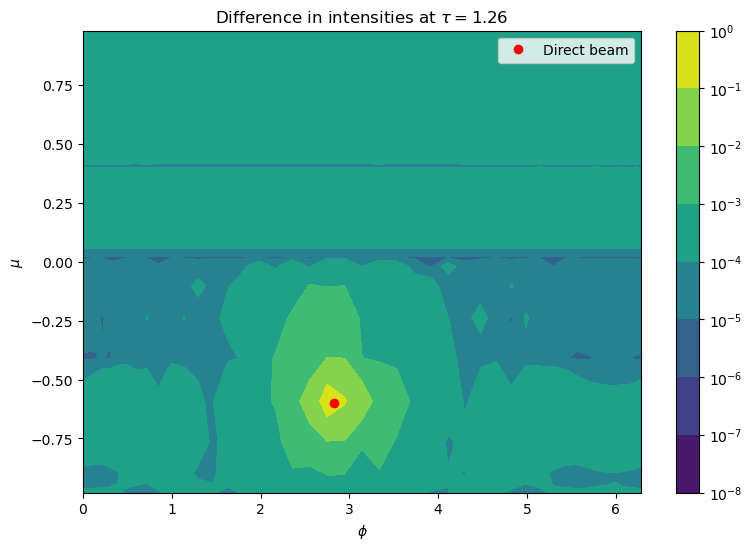

In [99]:
plot = diff[:, max_diff_tau_index, :]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot, norm=mpl.colors.LogNorm())
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(r"Difference in intensities at $\tau =$" + str(np.around(diff_tau_pt, 2)))
plt.legend()

In [100]:
print("At tau = " + str(diff_tau_pt))
print("Max pointwise difference =", np.max(diff[:, max_diff_tau_index, :]))

At tau = 1.2579061399625324
Max pointwise difference = 0.15751220171469527


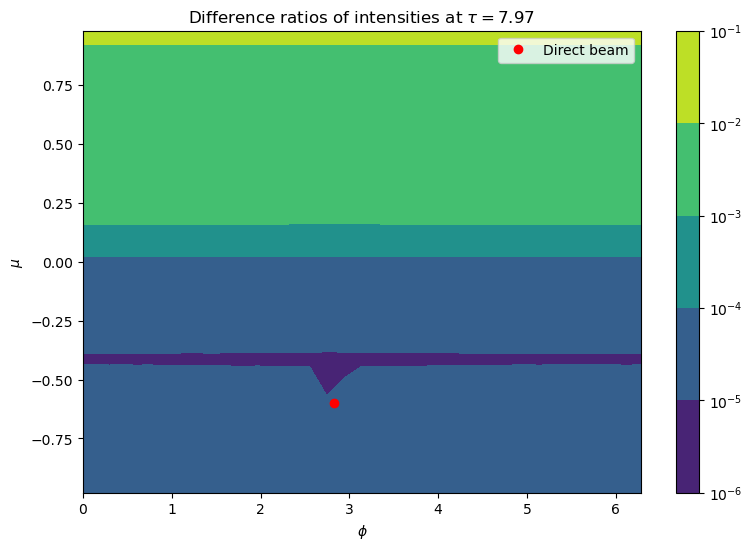

In [101]:
plot = diff_ratio[:, max_ratio_tau_index, :]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot, norm=mpl.colors.LogNorm())
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    r"Difference ratios of intensities at $\tau =$" + str(np.around(ratio_tau_pt, 2))
)
plt.legend()

In [102]:
print("At tau = " + str(ratio_tau_pt))
print("Max pointwise difference ratio =", np.max(diff_ratio[:, max_ratio_tau_index, :]))

At tau = 7.973694426971597
Max pointwise difference ratio = 0.022045273489288513


## 6.3 Intensity comparisons at interpolation points

In [103]:
Nmu = 50
mu_test_arr_pos = np.sort(np.random.random(size=Nmu))
mu_test_arr_neg = -np.flip(mu_test_arr_pos)
test_tau = 0.2
test_phi = pi

In [104]:
# Test Problem 3a:  Henyey-Greenstein Scattering (Compare To Ref. VH2, Table 37)
nlyr = NLayers
nmom = NLeg
nstr = NQuad
numu = 2 * Nmu
nphi = 1
ntau = 1
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to cmd instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.append(tau_arr[0], np.diff(tau_arr))
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = test_tau
umu0 = mu0
phi0 = phi0
umu = np.concatenate((mu_test_arr_neg, mu_test_arr_pos)) # Needs to be in increasing order
phi = test_phi
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = "Test Problem 3:  Henyey-Greenstein Scattering, g = 0.75 (Compare To Ref. VH2, Table 37)"
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu_interpol = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [105]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu_interpol, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu_interpol, albmed, trnmed)
else:
    results = np.load("section6_testresults2.npz")
    # Load saved results from Stamnes' DISORT
    uu_interpol = results["uu_interpol"]
    # Load comparison points
    mu_test_arr_pos = results["mu_test_arr_pos"]
    test_tau = results["test_tau"]
    test_phi = results["test_phi"]
    
    Nmu = len(mu_test_arr_pos)
    mu_test_arr_neg = -np.flip(mu_test_arr_pos)

In [106]:
'''
np.savez(
    "section6_testresults2",
    mu_test_arr_pos=mu_test_arr_pos,
    test_tau=test_tau,
    test_phi=test_phi,
    uu_interpol=uu_interpol,
)
'''

'\nnp.savez(\n    "section6_testresults2",\n    mu_test_arr_pos=mu_test_arr_pos,\n    test_tau=test_tau,\n    test_phi=test_phi,\n    uu_interpol=uu_interpol,\n)\n'

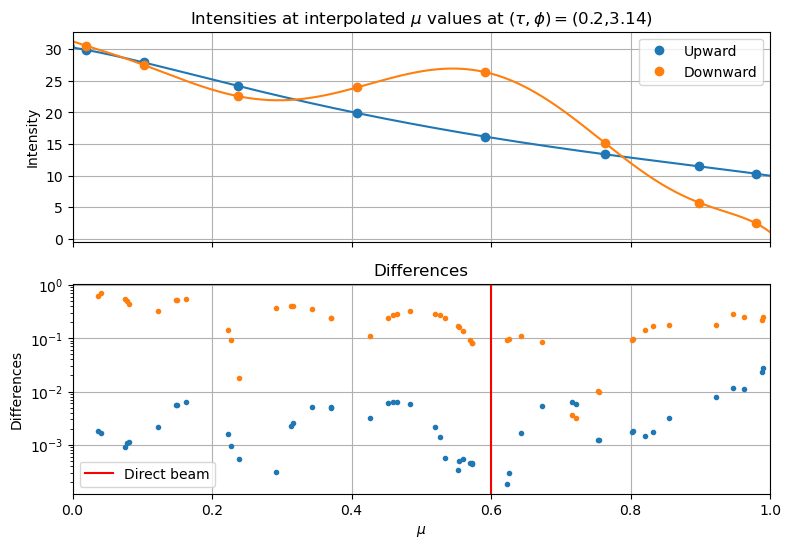

In [107]:
u_interpol = PythonicDISORT.subroutines.interpolate(u_NT)
mu_arr_plot = np.linspace(0, 1, 501)

fig = plt.figure(figsize=(9, 6))
plt.subplot((211))
plt.title(
    r"Intensities at interpolated $\mu$ values at $(\tau, \phi) =$"
    + "("
    + str(np.around(test_tau, 2))
    + ","
    + str(np.around(test_phi, 2))
    + ")"
)
plt.xlim([0,1])
plt.tick_params(labelbottom=False)
plt.plot(mu_arr_plot, u_interpol(mu_arr_plot, test_tau, test_phi), color="#1f77b4")
plt.plot(mu_arr_pos, u_NT(test_tau, test_phi)[:N], "o", color="#1f77b4", label="Upward")
plt.plot(mu_arr_plot, u_interpol(-mu_arr_plot, test_tau, test_phi), color="#ff7f0e")
plt.plot(mu_arr_pos, u_NT(test_tau, test_phi)[N:], "o", color="#ff7f0e", label="Downward")
plt.ylabel("Intensity")
plt.legend()
plt.grid()

plt.subplot((212))
plt.title("Differences")
plt.xlim([0,1])
plt.semilogy(
    mu_test_arr_pos,
    np.abs(u_interpol(mu_test_arr_pos, test_tau, test_phi) - uu_interpol[Nmu:].ravel()),
    ".",
    color="#1f77b4"
)
plt.semilogy(
    -mu_test_arr_neg,
    np.abs(u_interpol(mu_test_arr_neg, test_tau, test_phi) - uu_interpol[:Nmu].ravel()),
    ".",
    color="#ff7f0e"
)
plt.axvline(mu0, color="red", label="Direct beam")
plt.ylabel("Differences")
plt.xlabel(r"$\mu$")
plt.legend()
plt.grid()

The interpolation seems to be less accurate (at least in a relative sense) near the atmospheric boundaries and near $\mu=0$ or $1$.

## 6.4 PyTest

We use PyTest to implement test problems 1 to 9 and 11 of version 4.0.99 of Stamnes' FORTRAN DISORT [[3]](#cite-Sta1999). Test problem 11 is equivalent to our verification test in section [4.1](#4.1-Verification-of-multi-layer-solver). All test parameters are copied from DISORT's `disotest.f90` and `DISOTESTAUX.f` unless stated otherwise. Except for test problem 11 which is an internal consistency test, we compare the solutions from PythonicDISORT against corresponding solutions from Stamnes' DISORT which are saved in `.npz` files.

We compare fluxes at the $\tau$ points given in `disotest.f90`, and at $\mu$ and $\phi$ quadrature points for the intensity. For some tests, we do not compare intensity values at polar angles that are within $10^\circ$ of the direct beam. Our test criteria is that every point that has difference greater than $10^{-3}$ must have a difference ratio of less than $10^{-2}$ $(1\%)$ for the intensity, or $10^{-3}$ $(0.1\%)$ for the fluxes. **With PyTest installed, execute the console command** `pytest` **in the** `pydisotest` **directory to run these tests.**  Add the flag `-s` to print the differences to console.

## 6.5 Timing Stamnes' DISORT

Note that we time our F2PY-wrapped Stamnes' DISORT rather than the original FORTRAN DISORT [[3]](#cite-Sta1999) which will be even faster. Compare against PythonicDISORT's times in section [5](#5.-Timing-PythonicDISORT).

In [108]:
# Test Problem 3a:  Henyey-Greenstein Scattering (Compare To Ref. VH2, Table 37)
nlyr = NLayers
nmom = NLeg
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = False
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to cmd instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.append(tau_arr[0], np.diff(tau_arr))
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = "Test Problem 3:  Henyey-Greenstein Scattering, g = 0.75 (Compare To Ref. VH2, Table 37)"
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

**Time taken to compute the solution at just one point**

In [109]:
# Changed parameters
ntau = 1
utau = tau_test_arr_time[Ntau_time//2]
nphi = 1
phi = phi_arr_time[Nphi_time//2]


rho_accurate = np.zeros((numu, nphi))
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))

In [110]:
if disort_is_installed:
    print("Intensity")
    %timeit disort.disort(usrang, usrtau, ibcnd, False, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    print()

    print("Only fluxes")
    %timeit disort.disort(usrang, usrtau, ibcnd, True, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
else:
    print("RECENT TIMING TESTS")
    print()
    print("Intensity")
    print("7.19 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)")
    print()
    print("Only fluxes")
    print("855 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)")

Intensity
7.19 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Only fluxes
855 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Time taken to compute the solution at a large number of points**

In [111]:
# Changed parameters
ntau = Ntau_time
utau = tau_test_arr_time
nphi = Nphi_time
phi = phi_arr_time
print("Number of tau points =", ntau, ", Number of phi points =", nphi)


rho_accurate = np.zeros((numu, nphi))
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))

Number of tau points = 1000 , Number of phi points = 100


In [112]:
if disort_is_installed:
    print("Intensity")
    %timeit disort.disort(usrang, usrtau, ibcnd, False, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    print()

    print("Only fluxes")
    %timeit disort.disort(usrang, usrtau, ibcnd, True, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
else:
    print("RECENT TIMING TESTS")
    print()
    print("Intensity")
    print("3.51 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)")
    print()
    print("Only fluxes")
    print("23.2 ms ± 971 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)")

Intensity
3.51 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Only fluxes
23.2 ms ± 971 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


A surprisingly long time is taken by our F2PY-wrapped DISORT to compute the intensity at a large number of points.

<!--bibtex

@article{Sta1982,
title = {On the computation of angular distributions of radiation in planetary atmospheres},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {28},
number = {1},
pages = {47-51},
year = {1982},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(82)90096-6},
url = {https://www.sciencedirect.com/science/article/pii/0022407382900966},
author = {Knut Stamnes},
abstract = {The discrete ordinate approximation to the radiative transfer equation is used to derive simple analytic expressions for the intensity in a vertically inhomogeneous plane parallel atmosphere. This approach allows one to compute the intensity at arbitrary depths and angles. The merit and soundness of these expressions, which are interpolatory in nature, are discussed and it is conjectured that they are superior to any other standard interpolation scheme as far as accuracy is concerned. The computational time also compares favorably with that of standard interpolation schemes such as cubic splines.}
}

@software{CM2020,
author = {Connour, Kyle and Wolff, Michael},
license = {BSD-3-Clause},
title = {{pyRT_DISORT: A pre-processing front-end to help make DISORT simulations easier in Python}},
url = {https://github.com/kconnour/pyRT_DISORT},
version = {1.0.0},
year={2020}
}

@inbook{Tre1996,
  author    = {Trefethen, L. N.},
  title     = {In Finite difference and spectral methods for ordinary and partial differential equations},
  chapter   = {Chapter 8. Chebyshev spectral methods},
  year      = {1996},
  pages     = {260–300}
}

@article{NT1988,
title = {Algorithms for radiative intensity calculations in moderately thick atmospheres using a truncation approximation},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {40},
number = {1},
pages = {51-69},
year = {1988},
issn = {0022-4073},
doi = {10.1016/0022-4073(88)90031-3},
url = {https://www.sciencedirect.com/science/article/pii/0022407388900313},
author = {T. Nakajima and M. Tanaka},
abstract = {The efficiency of numerical calculations is discussed for selected algorithms employing the discrete ordinate method and the truncation approximation for the solar radiative intensity in moderately thick, plane-parallel scattering atmospheres. It is found that truncation of the phase function causes a significant error in the computed intensity and the magnitude of this error depends significantly on how the intensity is retrieved from the truncated radiative transfer equation. A newly developed retrieval algorithm, the IMS- method, yields the intensity field with an error ⪅1% when the number of discrete path is as small as 10 in the hemisphere for aerosol-laden atmospheres with optical thickness ⪅1.}
}

@article{YTA1971,
title = {Radiative heat transfer in water clouds by infrared radiation},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {11},
number = {6},
pages = {697-708},
year = {1971},
issn = {0022-4073},
doi = {10.1016/0022-4073(71)90048-3},
url = {https://www.sciencedirect.com/science/article/pii/0022407371900483},
author = {Giichi Yamamoto and Masayuki Tanaka and Shoji Asano},
abstract = {Radiative heat transfer in water clouds is studied by the method of discrete ordinates, taking into account not only scattering, absorption and emission by cloud droplets but also absorption and emission by water vapor in the cloud. According to Semuelson the method of discrete ordinates is not very amenable to studies involving the intermediate optical thickness, because of instabilities that are inherent in the method for the intermediate optical thickness. A method of avoiding these instabilities is shown in this paper. Numerical calculation for the spectral region from 5 to 40 μ was carried out on the model altostratus clouds, and that only for the window region on the model stratocumulus and nimbostratus clouds. The radiative temperature change in a very thin cloud is everywhere cooling. With increasing cloud thickness, however, the upper parts of the cloud undergo cooling, while the lower parts undergo heating. The rate of both heating and cooling is largest near the surface. In a semi-infinitely thick cloud the cloud top undergoes cooling at a rate of about 30°C/hr and effective cooling extends to about 100 m interior from the cloud boundary.}
}

@book{Cha1960, 
      author = "S.  Chandrasekhar",
      title = "Radiative Transfer",
      year = "1960",
      publisher = "Dover",
}

@article{Wis1977,
      author = "W. J.  Wiscombe",
      title = "The Delta–M Method: Rapid Yet Accurate Radiative Flux Calculations for Strongly Asymmetric Phase Functions",
      journal = "Journal of Atmospheric Sciences",
      year = "1977",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "34",
      number = "9",
      doi = "10.1175/1520-0469(1977)034<1408:TDMRYA>2.0.CO;2",
      pages=      "1408 - 1422",
      url = "https://journals.ametsoc.org/view/journals/atsc/34/9/1520-0469_1977_034_1408_tdmrya_2_0_co_2.xml"
}

@article{Syk1951,
    author = {Sykes, J. B.},
    title = "{Approximate Integration of the Equation of Transfer}",
    journal = {Monthly Notices of the Royal Astronomical Society},
    volume = {111},
    number = {4},
    pages = {377-386},
    year = {1951},
    month = {08},
    abstract = "{The value of numerical integration in obtaining approximate solutions of an equation of transfer, and the different methods at our disposal, are discussed. It is shown that although the Newton-Cotes method, used by Kourganoff, is better than the Gauss method, used by Chandrasekhar, both are inferior to a new method, the double-Gauss, discovered by the author. The errors in the approximate values of the source-function and the limb-darkening in all three methods are tabulated for various approximations, and illustrated by graphs.}",
    issn = {0035-8711},
    doi = {10.1093/mnras/111.4.377},
    url = {10.1093/mnras/111.4.377},
    eprint = {https://academic.oup.com/mnras/article-pdf/111/4/377/8077435/mnras111-0377.pdf},
}


@article{STWJ1988,
author = {Knut Stamnes and S-Chee Tsay and Warren Wiscombe and Kolf Jayaweera},
journal = {Appl. Opt.},
keywords = {Electromagnetic radiation; Multiple scattering; Optical depth; Radiative transfer; Reflection; Thermal emission},
number = {12},
pages = {2502--2509},
publisher = {Optica Publishing Group},
title = {Numerically stable algorithm for discrete-ordinate-method radiative transfer in multiple scattering and emitting layered media},
volume = {27},
month = {Jun},
year = {1988},
url = {http://opg.optica.org/ao/abstract.cfm?URI=ao-27-12-2502},
doi = {10.1364/AO.27.002502},
abstract = {We summarize an advanced, thoroughly documented, and quite general purpose discrete ordinate algorithm for time-independent transfer calculations in vertically inhomogeneous, nonisothermal, plane-parallel media. Atmospheric applications ranging from the UV to the radar region of the electromagnetic spectrum are possible. The physical processes included are thermal emission, scattering, absorption, and bidirectional reflection and emissionat the lower boundary. The medium may be forced at the top boundary by parallel or diffuse radiation and by internal and boundary thermal sources as well. We provide a brief account of the theoretical basis as well as a discussion of the numerical implementation of the theory. The recent advances made by ourselves and our collaborators---advances in both formulation and numerical solution---are all incorporated in the algorithm. Prominent among these advances are the complete conquest of two ill-conditioning problems which afflicted all previous discrete ordinate implementations: (1) the computation of eigenvalues and eigenvectors and (2) the inversion of the matrix determining the constants of integration. Copies of the fortran program on microcomputer diskettes are available for interested users.},
}



@article{STWLE2000,
author = {Stamnes, Knut and Tsay, Si-Chee and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco},
year = {2000},
month = {02},
pages = {},
title = {General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT}
}

@article{SS1981,
      author = "Knut  Stamnes and Roy A.  Swanson",
      title = "A New Look at the Discrete Ordinate Method for Radiative Transfer Calculations in Anisotropically Scattering Atmospheres",
      journal = "Journal of Atmospheric Sciences",
      year = "1981",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "38",
      number = "2",
      doi = "10.1175/1520-0469(1981)038<0387:ANLATD>2.0.CO;2",
      pages=      "387 - 399",
      url = "https://journals.ametsoc.org/view/journals/atsc/38/2/1520-0469_1981_038_0387_anlatd_2_0_co_2.xml"
}

@article{SC1984,
title = {A new multi-layer discrete ordinate approach to radiative transfer in vertically inhomogeneous atmospheres},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {31},
number = {3},
pages = {273-282},
year = {1984},
issn = {0022-4073},
doi = {10.1016/0022-4073(84)90031-1},
url = {https://www.sciencedirect.com/science/article/pii/0022407384900311},
author = {Knut Stamnes and Paul Conklin},
abstract = {A recently developed matrix formulation of the discrete ordinate method is extended for application to an inhomogeneous atmosphere. The solution yields fluxes, as well as the complete azimuthal dependence of the intensity at any level in the atmosphere. The numerical aspects of the solution are discussed and numerical verification is provided by comparing computed results with those obtained by other methods. In particular, it is shown that a simple scaling scheme, which removes the positive exponentials in the coefficient matrix when solving for the constants of integration, provides unconditionally stable solutions for arbitrary optical thicknesses. An assessment of the accuracy to be expected is also provided, and it is shown that low-order discrete ordinate approximations yield very accurate flux values.}
}

@article{MH2017,
title = {A demonstration of adjoint methods for multi-dimensional remote sensing of the atmosphere and surface},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {204},
pages = {215-231},
year = {2018},
issn = {0022-4073},
doi = {10.1016/j.jqsrt.2017.09.031},
url = {https://www.sciencedirect.com/science/article/pii/S0022407317305198},
author = {William G.K. Martin and Otto P. Hasekamp},
keywords = {Adjoint methods, Three-dimensional vector radiative transfer, Linearization, Remote sensing, Parameter derivatives, Searchlight functions},
abstract = {In previous work, we derived the adjoint method as a computationally efficient path to three-dimensional (3D) retrievals of clouds and aerosols. In this paper we will demonstrate the use of adjoint methods for retrieving two-dimensional (2D) fields of cloud extinction. The demonstration uses a new 2D radiative transfer solver (FSDOM). This radiation code was augmented with adjoint methods to allow efficient derivative calculations needed to retrieve cloud and surface properties from multi-angle reflectance measurements. The code was then used in three synthetic retrieval studies. Our retrieval algorithm adjusts the cloud extinction field and surface albedo to minimize the measurement misfit function with a gradient-based, quasi-Newton approach. At each step we compute the value of the misfit function and its gradient with two calls to the solver FSDOM. First we solve the forward radiative transfer equation to compute the residual misfit with measurements, and second we solve the adjoint radiative transfer equation to compute the gradient of the misfit function with respect to all unknowns. The synthetic retrieval studies verify that adjoint methods are scalable to retrieval problems with many measurements and unknowns. We can retrieve the vertically-integrated optical depth of moderately thick clouds as a function of the horizontal coordinate. It is also possible to retrieve the vertical profile of clouds that are separated by clear regions. The vertical profile retrievals improve for smaller cloud fractions. This leads to the conclusion that cloud edges actually increase the amount of information that is available for retrieving the vertical profile of clouds. However, to exploit this information one must retrieve the horizontally heterogeneous cloud properties with a 2D (or 3D) model. This prototype shows that adjoint methods can efficiently compute the gradient of the misfit function. This work paves the way for the application of similar methods to 3D remote sensing problems.}
}

@article{MCB2014,
title = {Adjoint methods for adjusting three-dimensional atmosphere and surface properties to fit multi-angle/multi-pixel polarimetric measurements},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {144},
pages = {68-85},
year = {2014},
issn = {0022-4073},
doi = {10.1016/j.jqsrt.2014.03.030},
url = {https://www.sciencedirect.com/science/article/pii/S002240731400154X},
author = {William Martin and Brian Cairns and Guillaume Bal},
keywords = {Adjoint methods, Three-dimensional vector radiative transfer, Linearization, Remote sensing, Parameter derivatives},
abstract = {This paper derives an efficient procedure for using the three-dimensional (3D) vector radiative transfer equation (VRTE) to adjust atmosphere and surface properties and improve their fit with multi-angle/multi-pixel radiometric and polarimetric measurements of scattered sunlight. The proposed adjoint method uses the 3D VRTE to compute the measurement misfit function and the adjoint 3D VRTE to compute its gradient with respect to all unknown parameters. In the remote sensing problems of interest, the scalar-valued misfit function quantifies agreement with data as a function of atmosphere and surface properties, and its gradient guides the search through this parameter space. Remote sensing of the atmosphere and surface in a three-dimensional region may require thousands of unknown parameters and millions of data points. Many approaches would require calls to the 3D VRTE solver in proportion to the number of unknown parameters or measurements. To avoid this issue of scale, we focus on computing the gradient of the misfit function as an alternative to the Jacobian of the measurement operator. The resulting adjoint method provides a way to adjust 3D atmosphere and surface properties with only two calls to the 3D VRTE solver for each spectral channel, regardless of the number of retrieval parameters, measurement view angles or pixels. This gives a procedure for adjusting atmosphere and surface parameters that will scale to the large problems of 3D remote sensing. For certain types of multi-angle/multi-pixel polarimetric measurements, this encourages the development of a new class of three-dimensional retrieval algorithms with more flexible parametrizations of spatial heterogeneity, less reliance on data screening procedures, and improved coverage in terms of the resolved physical processes in the Earth׳s atmosphere.}
}

@article{LSJLTWS2015,
title = {Improved discrete ordinate solutions in the presence of an anisotropically reflecting lower boundary: Upgrades of the DISORT computational tool},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {157},
pages = {119-134},
year = {2015},
issn = {0022-4073},
doi = {10.1016/j.jqsrt.2015.02.014},
url = {https://www.sciencedirect.com/science/article/pii/S0022407315000679},
author = {Z. Lin and S. Stamnes and Z. Jin and I. Laszlo and S.-C. Tsay and W.J. Wiscombe and K. Stamnes},
keywords = {Radiative transfer model, BRDF, Cox–Munk, Ross–Li, RPV, Single scattering correction},
abstract = {A successor version 3 of DISORT (DISORT3) is presented with important upgrades that improve the accuracy, efficiency, and stability of the algorithm. Compared with version 2 (DISORT2 released in 2000) these upgrades include (a) a redesigned BRDF computation that improves both speed and accuracy, (b) a revised treatment of the single scattering correction, and (c) additional efficiency and stability upgrades for beam sources. In DISORT3 the BRDF computation is improved in the following three ways: (i) the Fourier decomposition is prepared “off-line”, thus avoiding the repeated internal computations done in DISORT2; (ii) a large enough number of terms in the Fourier expansion of the BRDF is employed to guarantee accurate values of the expansion coefficients (default is 200 instead of 50 in DISORT2); (iii) in the post-processing step the reflection of the direct attenuated beam from the lower boundary is included resulting in a more accurate single scattering correction. These improvements in the treatment of the BRDF have led to improved accuracy and a several-fold increase in speed. In addition, the stability of beam sources has been improved by removing a singularity occurring when the cosine of the incident beam angle is too close to the reciprocal of any of the eigenvalues. The efficiency for beam sources has been further improved from reducing by a factor of 2 (compared to DISORT2) the dimension of the linear system of equations that must be solved to obtain the particular solutions, and by replacing the LINPAK routines used in DISORT2 by LAPACK 3.5 in DISORT3. These beam source stability and efficiency upgrades bring enhanced stability and an additional 5–7% improvement in speed. Numerical results are provided to demonstrate and quantify the improvements in accuracy and efficiency of DISORT3 compared to DISORT2.}
}

@article {JWW1976,
      author = "J. H.  Joseph and W. J.  Wiscombe and J. A.  Weinman",
      title = "The Delta-Eddington Approximation for Radiative Flux Transfer",
      journal = "Journal of Atmospheric Sciences",
      year = "1976",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "33",
      number = "12",
      doi = "10.1175/1520-0469(1976)033<2452:TDEAFR>2.0.CO;2",
      pages=      "2452 - 2459",
      url = "https://journals.ametsoc.org/view/journals/atsc/33/12/1520-0469_1976_033_2452_tdeafr_2_0_co_2.xml"
}

@Article{HMMNPW2017,
AUTHOR = {Hase, N. and Miller, S. M. and Maa{\ss}, P. and Notholt, J. and Palm, M. and Warneke, T.},
TITLE = {Atmospheric inverse modeling via sparse reconstruction},
JOURNAL = {Geoscientific Model Development},
VOLUME = {10},
YEAR = {2017},
NUMBER = {10},
PAGES = {3695--3713},
URL = {https://gmd.copernicus.org/articles/10/3695/2017/},
DOI = {10.5194/gmd-10-3695-2017}
}

@article {FL1992,
      author = "Qiang  Fu and K. N.  Liou",
      title = "On the Correlated k-Distribution Method for Radiative Transfer in Nonhomogeneous Atmospheres",
      journal = "Journal of Atmospheric Sciences",
      year = "1992",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "49",
      number = "22",
      doi = "10.1175/1520-0469(1992)049<2139:OTCDMF>2.0.CO;2",
      pages=      "2139 - 2156",
      url = "https://journals.ametsoc.org/view/journals/atsc/49/22/1520-0469_1992_049_2139_otcdmf_2_0_co_2.xml"
}

@inproceedings{FJ1999,
  title={Computer-based underwater imaging analysis},
  author={Georges R. Fournier and Miroslaw Jonasz},
  booktitle={Optics \& Photonics},
  year={1999}
}

@article{DM2010,
	doi = {10.1088/0034-4885/73/2/026801},
	url = {10.1088/0034-4885/73/2/026801},
	year = 2010,
	month = {jan},
	publisher = {{IOP} Publishing},
	volume = {73},
	number = {2},
	pages = {026801},
	author = {Anthony B Davis and Alexander Marshak},
	title = {Solar radiation transport in the cloudy atmosphere: a 3D perspective on observations and climate impacts},
	journal = {Reports on Progress in Physics},
	abstract = {The interplay of sunlight with clouds is a ubiquitous and often pleasant visual experience, but it conjures up major challenges for weather, climate, environmental science and beyond. Those engaged in the characterization of clouds (and the clear air nearby) by remote sensing methods are even more confronted. The problem comes, on the one hand, from the spatial complexity of real clouds and, on the other hand, from the dominance of multiple scattering in the radiation transport. The former ingredient contrasts sharply with the still popular representation of clouds as homogeneous plane-parallel slabs for the purposes of radiative transfer computations. In typical cloud scenes the opposite asymptotic transport regimes of diffusion and ballistic propagation coexist. We survey the three-dimensional (3D) atmospheric radiative transfer literature over the past 50 years and identify three concurrent and intertwining thrusts: first, how to assess the damage (bias) caused by 3D effects in the operational 1D radiative transfer models? Second, how to mitigate this damage? Finally, can we exploit 3D radiative transfer phenomena to innovate observation methods and technologies? We quickly realize that the smallest scale resolved computationally or observationally may be artificial but is nonetheless a key quantity that separates the 3D radiative transfer solutions into two broad and complementary classes: stochastic and deterministic. Both approaches draw on classic and contemporary statistical, mathematical and computational physics.}
}

@article{DFDM2021,
      author = "Linda Forster and Anthony B. Davis and David J. Diner and Bernhard Mayer",
      title = "Toward Cloud Tomography from Space Using MISR and MODIS: Locating the “Veiled Core” in Opaque Convective Clouds",
      journal = "Journal of the Atmospheric Sciences",
      year = "2021",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "78",
      number = "1",
      doi = "10.1175/JAS-D-19-0262.1",
      pages=      "155 - 166",
      url = "https://journals.ametsoc.org/view/journals/atsc/78/1/jas-d-19-0262.1.xml"
}

@article{DDET2022,
title = {Cloud tomographic retrieval algorithms. I: Surrogate minimization method},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {277},
pages = {107954},
year = {2022},
issn = {0022-4073},
doi = {10.1016/j.jqsrt.2021.107954},
url = {https://www.sciencedirect.com/science/article/pii/S0022407321004465},
author = {Adrian Doicu and Alexandru Doicu and Dmitry Efremenko and Thomas Trautmann},
keywords = {Cloud tomographic retrieval, Multi-dimensional models},
abstract = {A cloud tomographic retrieval algorithm relying on (i) the spherical harmonics discrete ordinate method for computing the radiative transfer and (ii) the surrogate minimization method for solving the inverse problem has been designed. The retrieval algorithm uses regularization, accelerated projected gradient methods, and two types of surrogate functions. The performances of the retrieval algorithm are analyzed on a few synthetic two- and three-dimensional problems.}
}

@misc{Sta1999, 
	title={LLLab disort website}, 
	url={http://www.rtatmocn.com/disort/}, 
	journal={Light and Life Lab (LLLab)}, 
	author={Stamnes, S.}, 
	year={1999}
} 

@INPROCEEDINGS{ALHSAV2020,
  author={Aides, Amit and Levis, Aviad and Holodovsky, Vadim and Schechner, Yoav Y. and Althausen, Dietrich and Vainiger, Adi},
  booktitle={2020 IEEE International Conference on Computational Photography (ICCP)}, 
  title={Distributed Sky Imaging Radiometry and Tomography}, 
  year={2020},
  volume={},
  number={},
  pages={1-12},
  doi={10.1109/ICCP48838.2020.9105241}}

@article {MW1980,
      author = "W. E.  Meador and W. R.  Weaver",
      title = "Two-Stream Approximations to Radiative Transfer in Planetary Atmospheres: A Unified Description of Existing Methods and a New Improvement",
      journal = "Journal of Atmospheric Sciences",
      year = "1980",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "37",
      number = "3",
      doi = "10.1175/1520-0469(1980)037<0630:TSATRT>2.0.CO;2",
      pages=      "630 - 643",
      url = "https://journals.ametsoc.org/view/journals/atsc/37/3/1520-0469_1980_037_0630_tsatrt_2_0_co_2.xml"
}


-->

# References

**1)** <a id="cite-STWJ1988"/><sup><a href=#ref-1>[^]</a><a href=#ref-3>[^]</a><a href=#ref-10>[^]</a><a href=#ref-19>[^]</a><a href=#ref-22>[^]</a><a href=#ref-29>[^]</a><a href=#ref-49>[^]</a></sup>Knut Stamnes and S-Chee Tsay and Warren Wiscombe and Kolf Jayaweera. 1988. _Numerically stable algorithm for discrete-ordinate-method radiative transfer in multiple scattering and emitting layered media_. [URL](http://opg.optica.org/ao/abstract.cfm?URI=ao-27-12-2502)

**2)** <a id="cite-Cha1960"/><sup><a href=#ref-2>[^]</a><a href=#ref-24>[^]</a></sup>S.  Chandrasekhar. 1960. _Radiative Transfer_.

**3)** <a id="cite-Sta1999"/><sup><a href=#ref-4>[^]</a><a href=#ref-5>[^]</a><a href=#ref-7>[^]</a><a href=#ref-8>[^]</a><a href=#ref-9>[^]</a><a href=#ref-12>[^]</a><a href=#ref-14>[^]</a><a href=#ref-15>[^]</a><a href=#ref-16>[^]</a><a href=#ref-17>[^]</a><a href=#ref-27>[^]</a><a href=#ref-50>[^]</a><a href=#ref-52>[^]</a><a href=#ref-53>[^]</a></sup>Stamnes, S.. 1999. _LLLab disort website_. [URL](http://www.rtatmocn.com/disort/)

**4)** <a id="cite-SC1984"/><sup><a href=#ref-6>[^]</a><a href=#ref-32>[^]</a><a href=#ref-48>[^]</a></sup>Knut Stamnes and Paul Conklin. 1984. _A new multi-layer discrete ordinate approach to radiative transfer in vertically inhomogeneous atmospheres_. [URL](https://www.sciencedirect.com/science/article/pii/0022407384900311)

**5)** <a id="cite-Wis1977"/><sup><a href=#ref-11>[^]</a><a href=#ref-20>[^]</a></sup>W. J.  Wiscombe. 1977. _The Delta–M Method: Rapid Yet Accurate Radiative Flux Calculations for Strongly Asymmetric Phase Functions_. [URL](https://journals.ametsoc.org/view/journals/atsc/34/9/1520-0469_1977_034_1408_tdmrya_2_0_co_2.xml)

**6)** <a id="cite-JWW1976"/><sup><a href=#ref-13>[^]</a><a href=#ref-21>[^]</a></sup>J. H.  Joseph and W. J.  Wiscombe and J. A.  Weinman. 1976. _The Delta-Eddington Approximation for Radiative Flux Transfer_. [URL](https://journals.ametsoc.org/view/journals/atsc/33/12/1520-0469_1976_033_2452_tdeafr_2_0_co_2.xml)

**7)** <a id="cite-Syk1951"/><sup><a href=#ref-23>[^]</a><a href=#ref-26>[^]</a></sup>Sykes, J. B.. 1951. _Approximate Integration of the Equation of Transfer_. [URL](10.1093/mnras/111.4.377)

**8)** <a id="cite-STWLE2000"/><sup><a href=#ref-25>[^]</a><a href=#ref-28>[^]</a><a href=#ref-35>[^]</a><a href=#ref-36>[^]</a><a href=#ref-38>[^]</a><a href=#ref-39>[^]</a><a href=#ref-40>[^]</a><a href=#ref-42>[^]</a><a href=#ref-43>[^]</a><a href=#ref-44>[^]</a><a href=#ref-45>[^]</a></sup>Stamnes, Knut and Tsay, Si-Chee and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco. 2000. _General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT_.

**9)** <a id="cite-LSJLTWS2015"/><sup><a href=#ref-30>[^]</a><a href=#ref-31>[^]</a><a href=#ref-46>[^]</a><a href=#ref-47>[^]</a></sup>Z. Lin and S. Stamnes and Z. Jin and I. Laszlo and S.-C. Tsay and W.J. Wiscombe and K. Stamnes. 2015. _Improved discrete ordinate solutions in the presence of an anisotropically reflecting lower boundary: Upgrades of the DISORT computational tool_. [URL](https://www.sciencedirect.com/science/article/pii/S0022407315000679)

**10)** <a id="cite-Tre1996"/><sup><a href=#ref-33>[^]</a></sup>Trefethen, L. N.. 1996. _In Finite difference and spectral methods for ordinary and partial differential equations_.

**11)** <a id="cite-Sta1982"/><sup><a href=#ref-34>[^]</a></sup>Knut Stamnes. 1982. _On the computation of angular distributions of radiation in planetary atmospheres_. [URL](https://www.sciencedirect.com/science/article/pii/0022407382900966)

**12)** <a id="cite-NT1988"/><sup><a href=#ref-37>[^]</a><a href=#ref-41>[^]</a></sup>T. Nakajima and M. Tanaka. 1988. _Algorithms for radiative intensity calculations in moderately thick atmospheres using a truncation approximation_. [URL](https://www.sciencedirect.com/science/article/pii/0022407388900313)

**13)** <a id="cite-CM2020"/><sup><a href=#ref-51>[^]</a></sup>Connour, Kyle and Wolff, Michael. 2020. _pyRT_DISORT: A pre-processing front-end to help make DISORT simulations easier in Python_. [URL](https://github.com/kconnour/pyRT_DISORT)

